# Generate collection-analysis Database from Sierra Database

This notebook will generate a single sqlite3 database file, `current_collection.db` with wal-mode disabled (wal-mode is enabled, but then turned off to improve the insert process--see the sqlite-utils docs for more details: https://sqlite-utils.datasette.io/en/3.24/python-api.html#wal-mode) 

## Notable Parts of this Notebook

* <a href='#Build-record_metadata-table'>Build record_metadata table</a>
* <a href='#Finishing-Build-of-Primary-DB'>Finishing Build of Primary Database</a>
* <a href='#Building-Useful-Views'>Building Views</a>

## Primary Software Used

* **Datasette** ( https://docs.datasette.io/en/stable/ ) 
    * 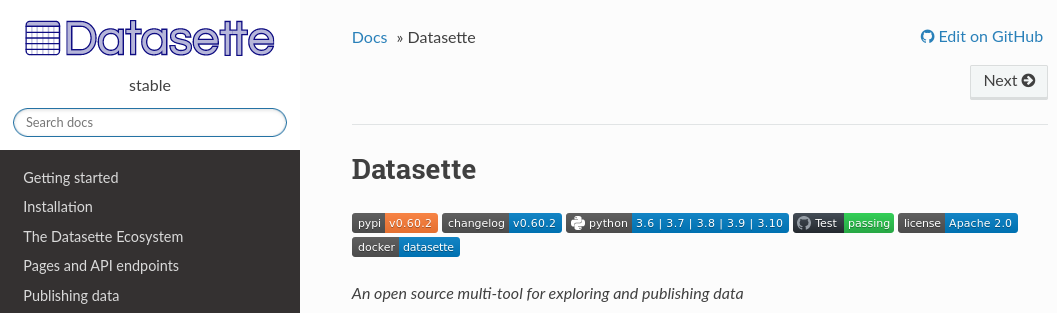
    * > An open source multi-tool for exploring and publishing data
    * Datasette will utilize the SQLite database built by this notebook
* **sqlite-utils** ( https://sqlite-utils.datasette.io ) 
    * 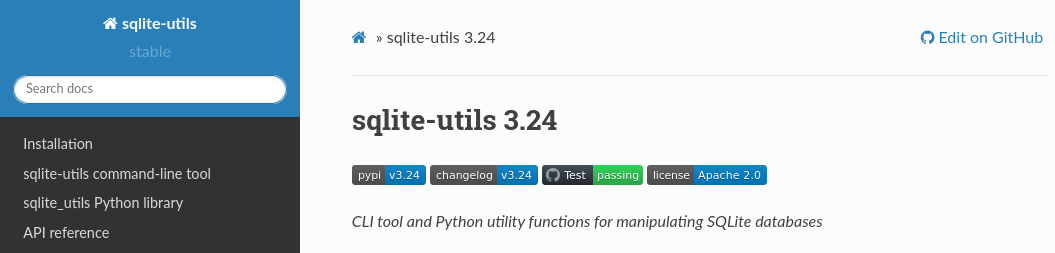
    * > CLI tool and Python utility functions for manipulating SQLite databases
    * This Python untility is used to create and then interface with SQLite db that will then be hosted by Datasette
* **SQLAlchemy** ( https://www.sqlalchemy.org/ ) 
    * 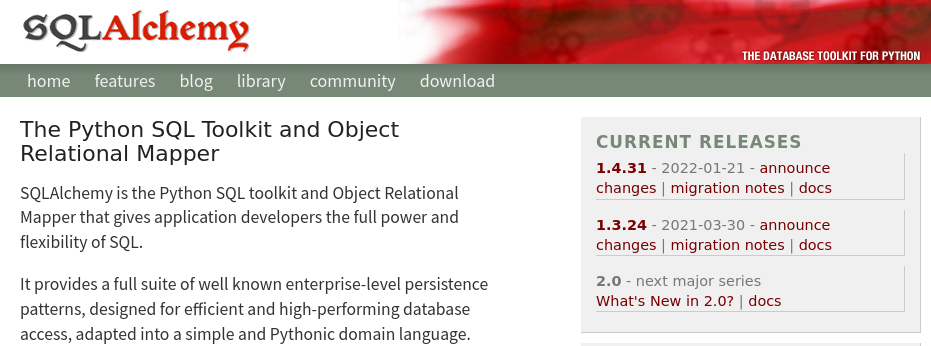
    * > The Python SQL Toolkit and Object Relational Mapper
    * Using the `create_engine` tool from this module provides an easy-to-use interface for accessing the postgresql database

## The Basic Recipe / Pattern

This script is designed to be run on a daily or weekly basis

* Running this script on a regular basis ...
    * **`daily`** updates an existing database--which will replace or insert new rows in tables based on _record last updated_ values
    * **`weekly`** refreshes the database entirely
* Extract data from Sierra
    * the idea is to primarily target **bib**, **item**, **volume** record data

Using the SQLAlchemy `create_engine` / `Engine` object, we can create SQL queries, and execute them on the Sierra DB server, return results, and then insert those values using the sqlite-utils Python utility.

In [1]:
!pwd
!which python

/home/plchuser/collection-analysis
/home/plchuser/collection-analysis/venv/bin/python


In [2]:
# !pip install -U pip
# !pip install -U sqlalchemy
# !pip install -U psycopg2-binary
# !pip install -U sqlite-utils
# !pip install -U jupyterlab_code_formatter black isort

In [82]:
import csv
import json
import os
from time import sleep

from sqlalchemy import create_engine
from sqlalchemy.sql import text
from sqlite_utils import Database

# pull in some data from the config to set db auth
try:
    with open("config.json", "r") as f:
        config = json.load(f)

    pg_username = config["pg_username"]
    pg_password = config["pg_password"]
    output_dir = config["output_dir"]
    
    current_collection_db = output_dir + 'current_collection.db'
    output_current_collection_db = output_dir + 'output_current_collection.db'

except:
    exit()

In [4]:
# this cell is tagged "parameters"
# https://papermill.readthedocs.io/en/latest/usage-parameterize.html

# gen_collection = 'daily'
gen_collection = 'weekly'

In [5]:
# this will take parameters for papermill (from the previous cell)
#   to use on the CLI to send values to this notebook
if gen_collection == 'daily':
    db = Database(current_collection_db, recreate=False)
else:
    # weekly or default to weekly
    db = Database(current_collection_db, recreate=True)

db.enable_wal()
print(db.journal_mode)

# sqlalchemy
# set up the connections to the local db and remote db
sierra_engine = create_engine(
    'postgresql://{}:{}@sierra-db.plch.net:1032/iii'.format(
        pg_username,
        pg_password
    )
)

wal


In [6]:
# if we're doing this daily, then find the date we need to target
# when looking for records modified since the last snapshot
target_date = "1969-01-01 00:00:00"

# NOTE, that we're OK with some overlap here... better to go back further than to miss records
# with a daily update / refresh
try:
    value = db.execute(
        """\
        SELECT
        datetime(max(record_last_updated_julianday), '-1 day')
        FROM
        record_metadata"""
    ).fetchone()[0]
    if value is not None:
        target_date = value
except:
    pass

print("target_date:", target_date)

target_date: 1969-01-01 00:00:00


# Build record_metadata table

In [7]:
# record_metadata
#

db["record_metadata"].create(
    {
        "record_id": int,
        "record_num": int,
        "record_type_code": str,
        "creation_julianday": int,
        "record_last_updated_julianday": int,
        "deletion_julianday": int,
    },
    pk="record_id",
    if_not_exists=True,
)

sql = text(
    """\
WITH record_data AS (  
    SELECT
    r.id
    FROM
    sierra_view.record_metadata AS r
    WHERE
    r.record_type_code in ('b', 'i', 'j')
    AND r.campus_code = ''
    AND (
        r.deletion_date_gmt >= :target_date :: timestamptz 
        OR r.record_last_updated_gmt >= :target_date :: timestamptz 
    )
    AND r.id > :id_val -- paginate by the id, rather than an offset  
    ORDER BY r.id ASC
    LIMIT :limit_val 
)
SELECT 
d.id AS record_id,
r.record_num as record_num,
r.record_type_code,
to_char(r.creation_date_gmt, 'J')::INTEGER AS creation_julianday,
to_char(r.record_last_updated_gmt, 'J')::INTEGER AS record_last_updated_julianday,
to_char(r.deletion_date_gmt, 'J')::INTEGER AS deletion_julianday
FROM 
record_data AS d
JOIN sierra_view.record_metadata AS r ON r.id = d.id
"""
)
# --

limit_val = 100000
id_val = 0  # paginate by the id, rather than an offset

while True:
    # https://docs.sqlalchemy.org/en/14/core/connections.html
    with sierra_engine.connect() as conn:
        cursor = conn.execute(
            sql, target_date=target_date, limit_val=limit_val, id_val=id_val
        )
        print("#", end="")

        # returns a list of dictionaries
        # https://docs.sqlalchemy.org/en/14/core/connections.html#sqlalchemy.engine.RowMapping
        rows = cursor.mappings().all()
        if len(rows) == 0:
            break

        db["record_metadata"].insert_all(rows, pk="record_id", replace=True)

        print(".", end="")

        try:
            # get the last id value from the row's we just inserted
            id_val = rows[-1]["record_id"]  # paginate by the id, rather than an offset
        except:
            print("!")
            break
        # offset_val+=limit_val

#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#

In [8]:
# bib
#

db["bib"].create(
    {
        "bib_record_num": int,
        "bib_record_id": int,
        "control_numbers": dict,
        "isbn_values": dict,
        "best_author": str,
        "best_title": str,
        "publisher": str,
        "publish_year": int,
        "bib_level_callnumber": str,
        "indexed_subjects": dict,
        "genres": dict,
        "item_types": dict,
        "cataloging_date": str,
    },
    pk="bib_record_num",
    if_not_exists=True,
)

sql = text("""\
WITH r AS (
    SELECT 
    rm.id,
    rm.record_num AS bib_record_num,
    rm.record_last_updated_gmt::date as record_last_updated
    FROM
    sierra_view.record_metadata AS rm
    WHERE 
    rm.record_type_code = 'b'
    AND rm.campus_code = ''
    AND rm.deletion_date_gmt IS NULL
    AND rm.record_last_updated_gmt >= :target_date :: timestamptz
    AND rm.id > :id_val -- paginate by the id, rather than an offset
    ORDER BY rm.id ASC
    LIMIT :limit_val
)
SELECT
r.bib_record_num,
r.id as bib_record_id,
(
    SELECT
    json_agg(po.index_entry ORDER BY po.occurrence, po.id)
    FROM
    sierra_view.phrase_entry as po
    WHERE
    po.record_id = r.id
    AND po.index_tag = 'o'
    AND po.varfield_type_code = 'o'
) AS control_numbers,
(
    WITH isbns AS (
    SELECT
    regexp_matches(
        v.field_content,
        '[0-9]{9,10}[x]{0,1}|[0-9]{12,13}[x]{0,1}', -- the regex to match on (10 or 13 digits, with the possibility of the 'X' character in the check-digit spot)
        'i' -- regex flags ignore case
    ) AS matches
    FROM
    sierra_view.varfield as v
    WHERE
    v.record_id = r.id
    AND v.marc_tag || v.varfield_type_code = '020i'
    ORDER BY 
    v.occ_num
  )
  SELECT 
  json_agg(isbns.matches[1])
  FROM isbns 
) AS isbn_values,
p.best_author,
p.best_title,
(
    SELECT
    s.content
    FROM
    sierra_view.subfield as s
    WHERE
    s.record_id = r.id
    AND s.field_type_code = 'p'
    AND s.tag = 'b'
    ORDER BY
    s.display_order
    LIMIT 1
) as publisher,
p.publish_year,
-- the normalized call number on the bib
(
    SELECT
    pc.index_entry
    FROM
    sierra_view.phrase_entry as pc
    WHERE
    pc.record_id = r.id
    AND pc.index_tag = 'c'
    AND pc.varfield_type_code = 'c'
    ORDER BY
    pc.id
    LIMIT 1
) as bib_level_callnumber,
(
    SELECT
    json_agg(p.index_entry ORDER BY p.occurrence, p.id) as subject
    FROM
    sierra_view.phrase_entry as p
    WHERE
    p.record_id = r.id
    AND p.index_tag = 'd'
) as indexed_subjects,
(
    select 
    json_agg(s."content" order by s.occ_num)
    from 
    sierra_view.record_metadata rm 
    join sierra_view.varfield as v on (v.varfield_type_code = 'j' and v.record_id = rm.id)
    join sierra_view.subfield as s on s.varfield_id = v.id   
    where 
    (rm.record_type_code = 'b' and rm.record_num = r.bib_record_num and rm.campus_code = '')
    and s.tag = 'a'
) as genres,
(
    with attached_items as (
        select 
            ir.itype_code_num,
            count(*) as count_items
        from 
            sierra_view.bib_record_item_record_link as brirl
            join sierra_view.item_record as ir on ir.record_id = brirl.item_record_id
        where 
            brirl.bib_record_id = r.id
        group by 
            1 
    )
    select 
    json_agg(ipn."name" order by count_items desc)
    from 
        attached_items
        join sierra_view.itype_property as ip on ip.code_num = attached_items.itype_code_num
        join sierra_view.itype_property_name as ipn on ipn.itype_property_id = ip.id
) as item_types, 
br.cataloging_date_gmt::date AS cataloging_date
FROM 
r
JOIN sierra_view.bib_record AS br ON br.record_id = r.id
LEFT OUTER JOIN sierra_view.bib_record_property AS p ON p.bib_record_id = r.id
""")

limit_val = 10000
id_val = 0  # paginate by the id, rather than an offset

while True:
    # https://docs.sqlalchemy.org/en/14/core/connections.html
    with sierra_engine.connect() as conn:
        cursor = conn.execute(
            sql, target_date=target_date, limit_val=limit_val, id_val=id_val
        )
        print("#", end="")

        # returns a list of dictionaries
        # https://docs.sqlalchemy.org/en/14/core/connections.html#sqlalchemy.engine.RowMapping
        rows = cursor.mappings().all()
        if len(rows) == 0:
            break

        db["bib"].insert_all(rows, pk="bib_record_num", replace=True)

        print(".", end="")

        try:
            # get the last id value from the row's we just inserted
            id_val = rows[-1][
                "bib_record_id"
            ]  # paginate by the id, rather than an offset
        except:
            print("!")
            break
        # offset_val+=limit_val

#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#

In [9]:
# item
#

db["item"].create(
    {
        "item_record_num": int,
        "item_record_id": int,
        "bib_record_num": int,
        "creation_date": str,
        "record_last_updated": str,
        "barcode": str,
        "agency_code_num": int,
        "location_code": str,
        "checkout_statistic_group_code_num": int,
        "checkin_statistics_group_code_num": int,
        "checkout_date": str,
        "due_date": str,
        "patron_branch_code": str,
        "last_checkout_date": str,
        "last_checkin_date": str,
        "checkout_total": int,
        "renewal_total": int,
        "item_format": str,
        "item_status_code": str,
        "price_cents": int,
        "item_callnumber": str,
        "volume_record_num": int,
        "volume_record_statement": str,
    },
    pk="item_record_num",
    # TODO: 
    # figure out if this adds any value
    # foreign_keys=[
    #     ("bib_record_num", "bib", "bib_record_num")
    #     # this says, "create a link from item to bib on the "bib_record_num" key (it happens to be the same name)
    # ],
    if_not_exists=True,
)

sql = text(
    """\
WITH r AS (
    SELECT
    rm.id,
    rm.record_num, 
    rm.creation_date_gmt,
    rm.record_last_updated_gmt 
    FROM
    sierra_view.record_metadata AS rm 
    WHERE
    rm.record_type_code = 'i'
    AND rm.campus_code = ''
    AND rm.deletion_date_gmt is NULL
    AND rm.record_last_updated_gmt >= :target_date :: timestamptz
    AND rm.id > :id_val
    ORDER BY 
    rm.id ASC
    LIMIT :limit_val
),
temp_map_item_type AS (
    SELECT
    p.code_num as code,
    n.name as name
    FROM
    sierra_view.itype_property as p
    JOIN
    sierra_view.itype_property_name as n
    ON
      n.itype_property_id = p.id
)
SELECT
r.record_num as item_record_num,
r.id AS item_record_id,
br.record_num as bib_record_num,
r.creation_date_gmt::date AS creation_date,
r.record_last_updated_gmt::date as record_last_updated,
p.barcode,
i.agency_code_num,
i.location_code,
i.checkout_statistic_group_code_num,
i.checkin_statistics_group_code_num,
c.checkout_gmt::date as checkout_date,
c.due_gmt::date as due_date,
(
    SELECT
    p.home_library_code
    FROM
    sierra_view.patron_record as p
    WHERE
    p.record_id = c.patron_record_id
    LIMIT 1
) as patron_branch_code,
i.last_checkout_gmt::date as last_checkout_date,
i.last_checkin_gmt::date as last_checkin_date,
i.checkout_total,
i.renewal_total,
(
    SELECT
    t.name
    FROM
    temp_map_item_type AS t	
    WHERE
    t.code = i.itype_code_num
    LIMIT 1
) as item_format,
i.item_status_code,
(i.price * 100.0)::INTEGER AS price_cents,
p.call_number_norm AS item_callnumber,
rm2.record_num AS volume_record_num,
(
    SELECT
    string_agg(v.field_content, ', ' ORDER BY v.occ_num)
    FROM
    sierra_view.varfield AS v
    WHERE
    v.record_id = rm2.id 
    AND v.varfield_type_code = 'v'
) AS volume_record_statement
FROM r
JOIN sierra_view.item_record_property as p ON p.item_record_id = r.id
JOIN sierra_view.item_record as i ON i.record_id = r.id
LEFT OUTER JOIN sierra_view.checkout as c ON c.item_record_id = r.id
JOIN sierra_view.bib_record_item_record_link as l ON l.item_record_id = r.id
JOIN sierra_view.record_metadata as br ON br.id = l.bib_record_id
LEFT OUTER JOIN sierra_view.volume_record_item_record_link AS vrirl ON vrirl.item_record_id = r.id
LEFT OUTER JOIN sierra_view.record_metadata AS rm2 ON rm2.id = vrirl.volume_record_id  
"""
)

limit_val = 10000
id_val = 0  # paginate by the id, rather than an offset

while True:
    # https://docs.sqlalchemy.org/en/14/core/connections.html
    with sierra_engine.connect() as conn:
        cursor = conn.execute(
            sql, target_date=target_date, limit_val=limit_val, id_val=id_val
        )
        print("#", end="")

        # returns a list of dictionaries
        # https://docs.sqlalchemy.org/en/14/core/connections.html#sqlalchemy.engine.RowMapping
        rows = cursor.mappings().all()
        if len(rows) == 0:
            break

        db["item"].insert_all(rows, pk="item_record_num", replace=True)

        print(".", end="")

        try:
            # get the last id value from the row's we just inserted
            id_val = rows[-1][
                "item_record_id"
            ]  # paginate by the id, rather than an offset
        except:
            print("!")
            break
        # offset_val+=limit_val

#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.

In [10]:
# bib_record
#

db["bib_record"].create(
    {
        "id": int,
        "record_id": int,
        "language_code": str,
        "bcode1": str,
        "bcode2": str,
        "bcode3": str,
        "country_code": str,
        "index_change_count": int,
        "is_on_course_reserve": bool,
        "is_right_result_exact": bool,
        "allocation_rule_code": str,
        "skip_num": int,
        "cataloging_date_gmt": str,
        "marc_type_code": str,
        "is_suppressed": bool,
    },
    pk="id",
    if_not_exists=True,
)

sql = text(
    """\
SELECT
b.id,
b.record_id,
b.language_code,
b.bcode1,
b.bcode2,
b.bcode3,
b.country_code,
b.index_change_count,
b.is_on_course_reserve,
b.is_right_result_exact,
b.allocation_rule_code,
b.skip_num,
date(b.cataloging_date_gmt) AS cataloging_date_gmt,
b.marc_type_code,
b.is_suppressed
FROM
sierra_view.bib_record as b
JOIN sierra_view.record_metadata as r on r.id = b.record_id
WHERE
r.campus_code = ''
AND r.record_last_updated_gmt >= :target_date :: timestamptz
AND b.id > :id_val
ORDER BY
b.id ASC
LIMIT :limit_val
"""
)

limit_val = 100000
id_val = 0  # paginate by the id, rather than an offset

while True:
    # https://docs.sqlalchemy.org/en/14/core/connections.html
    with sierra_engine.connect() as conn:
        cursor = conn.execute(
            sql, target_date=target_date, limit_val=limit_val, id_val=id_val
        )
        print("#", end="")

        # returns a list of dictionaries
        # https://docs.sqlalchemy.org/en/14/core/connections.html#sqlalchemy.engine.RowMapping
        rows = cursor.mappings().all()
        if len(rows) == 0:
            break

        db["bib_record"].insert_all(rows, pk="id", replace=True)

        print(".", end="")

        try:
            # get the last id value from the row's we just inserted
            id_val = rows[-1]["id"]  # paginate by the id, rather than an offset
        except:
            print("!")
            break
        # offset_val+=limit_val

#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#

In [11]:
# volume_record
#

db["volume_record"].create(
    {
        "volume_record_id": int,
        "volume_record_num": int,
        "bib_record_id": int,
        "bib_record_num": int,
        "creation_julianday": int,
        "volume_statement": str,
    },
    pk="volume_record_id",
    if_not_exists=True,
)

sql = text(
    """
SELECT 
rm.id AS volume_record_id,
rm.record_num AS volume_record_num,
rm2.id AS bib_record_id,
rm2.record_num AS bib_record_num,
to_char(rm.creation_date_gmt, 'J') :: INTEGER as creation_julianday,
(
    SELECT
    string_agg(v.field_content, ', ' ORDER BY v.occ_num)
    FROM 
    sierra_view.varfield AS v 
    WHERE 
    v.record_id = vr.record_id 
) AS volume_statement
FROM 
sierra_view.volume_record AS vr
JOIN sierra_view.record_metadata AS rm ON rm.id = vr.record_id  
JOIN sierra_view.bib_record_volume_record_link AS brvrl ON brvrl.volume_record_id = vr.record_id  
JOIN sierra_view.record_metadata rm2 ON rm2.id = brvrl.bib_record_id
WHERE 
rm.record_last_updated_gmt >= :target_date :: timestamptz
AND rm.id > :id_val
ORDER BY 
rm.id ASC
LIMIT :limit_val
"""
)

limit_val = 100000
id_val = 0  # paginate by the id, rather than an offset

while True:
    # https://docs.sqlalchemy.org/en/14/core/connections.html
    with sierra_engine.connect() as conn:
        cursor = conn.execute(
            sql, target_date=target_date, limit_val=limit_val, id_val=id_val
        )
        print("#", end="")

        # returns a list of dictionaries
        # https://docs.sqlalchemy.org/en/14/core/connections.html#sqlalchemy.engine.RowMapping
        rows = cursor.mappings().all()
        if len(rows) == 0:
            break

        db["volume_record"].insert_all(rows, pk="id", replace=True)

        print(".", end="")

        try:
            # get the last id value from the row's we just inserted
            id_val = rows[-1][
                "volume_record_id"
            ]  # paginate by the id, rather than an offset
        except:
            print("!")
            break
        # offset_val+=limit_val

#.#.#.#.#

In [12]:
# item messages (for in transit info)
#

# always refresh this table
db["item_message"].drop(ignore=True)

db["item_message"].create(
    {
        "item_barcode": str,
        "campus_code": str,
        "call_number": str,
        "item_record_id": int,
        "varfield_id": int,
        "has_in_transit": bool,
        "in_transit_julianday": int,
        "in_transit_days": int,
        "transit_from": str,
        "transit_to": str,
        "has_in_transit_too_long": bool,
        "occ_num": int,
        "field_content": str,
        "publish_year": int,
        "best_title": str,
        "best_author": str,
        "item_status_code": str,
        "item_status_name": str,
        "agency_code_num": int,
        "location_code": str,
        "itype_code_num": int,
        "item_format": str,
        "due_julianday": int,
        "loanrule_code_num": int,
        "checkout_julianday": int,
        "renewal_count": int,
        "overdue_count": int,
        "overdue_julianday": int,
    }
)

# -- NOTE ... this part of the regex may need to be escaped (\:)depeding on the context
# -- '^[a-z]{3}\s[a-z]{1,3}\s[0-9]{2}\s[0-9]{4}\s[0-9]{2}\:[0-9]{2}(?\:AM|PM)',
# -- or
# -- '^[a-z]{3}\s[a-z]{1,3}\s[0-9]{2}\s[0-9]{4}\s[0-9]{2}\:[0-9]{2}(?:AM|PM)',

sql = text(
    """\
WITH item_messages AS (
    SELECT
    r.record_num AS item_record_num,
    r.id AS item_record_id,
    r.campus_code,
    v.id as varfield_id,
    v.occ_num,
    v.field_content,
    v.field_content ~* '.*IN\sTRANSIT.*' AS has_in_transit,
    v.field_content ~* '.*IN\sTRANSIT\sTOO\sLONG.*' AS has_in_transit_too_long,
    regexp_matches(
        v.field_content, 
        '.*IN\sTRANSIT\sfrom\s([0-9a-z]{1,})\sto\s([0-9a-z]{1,})',
        'gi'
    ) AS transit_from_to,
    (
        regexp_matches(
            v.field_content, 
            '^[a-z]{3}\s[a-z]{1,3}\s[0-9]{2}\s[0-9]{4}\s[0-9]{2}\:[0-9]{2}(?\:AM|PM)',
            --                                                              ^
            -- NOTE ... this part of the regex may need to be escaped (\:) or unescaped depeding on the context
            -- mostly for binding parameters 
            'gi'
        )
    )[1] AS transit_time_string
    FROM 
    sierra_view.record_metadata AS r
    JOIN sierra_view.varfield AS v ON v.record_id = r.id
    WHERE 
    r.record_type_code ='i'
    AND v.varfield_type_code = 'm'
    AND v.id > :id_val
    ORDER BY 
    v.id ASC,
    v.occ_num ASC
    LIMIT :limit_val
)
SELECT
irp.barcode AS item_barcode,
item_messages.campus_code,
irp.call_number,
-- item_messages.item_record_num, -- maybe avoid using this here, since these are in some cases virtual items
item_messages.item_record_id,
item_messages.varfield_id,
item_messages.has_in_transit,
TO_CHAR(item_messages.transit_time_string::TIMESTAMP, 'J')::INTEGER AS in_transit_julianday,
TO_CHAR('NOW'::TIMESTAMP, 'J')::INTEGER
    - TO_CHAR(item_messages.transit_time_string::TIMESTAMP, 'J')::INTEGER AS in_transit_days,
transit_from_to[1] AS transit_from,
transit_from_to[2] AS transit_to,
item_messages.has_in_transit_too_long,
item_messages.occ_num,
item_messages.field_content,
brp.publish_year,
brp.best_title,
brp.best_author,
ir.item_status_code,
ispn."name" AS item_status_name,
ir.agency_code_num,
ir.location_code,
ir.itype_code_num,
ipn."name" AS item_format,
TO_CHAR(c.due_gmt, 'J') :: INTEGER AS due_julianday,
c.loanrule_code_num,
TO_CHAR(c.checkout_gmt, 'J') :: INTEGER AS checkout_julianday,
c.renewal_count,
c.overdue_count,
TO_CHAR(c.overdue_gmt, 'J') :: INTEGER AS overdue_julianday 
FROM 
item_messages
LEFT OUTER JOIN sierra_view.item_record_property AS irp ON irp.item_record_id = item_messages.item_record_id
LEFT OUTER JOIN sierra_view.item_record AS ir ON ir.record_id = item_messages.item_record_id
LEFT OUTER JOIN sierra_view.checkout AS c ON c.item_record_id = ir.record_id  
LEFT OUTER JOIN sierra_view.item_status_property AS isp ON isp.code = ir.item_status_code 
LEFT OUTER JOIN sierra_view.item_status_property_name AS ispn ON ispn.item_status_property_id = isp.id
LEFT OUTER JOIN sierra_view.bib_record_item_record_link AS brirl ON brirl.item_record_id = item_messages.item_record_id
LEFT OUTER JOIN sierra_view.bib_record_property AS brp ON brp.bib_record_id = brirl.bib_record_id 
LEFT OUTER JOIN sierra_view.itype_property AS ip ON ip.code_num = ir.itype_code_num 
LEFT OUTER JOIN sierra_view.itype_property_name AS ipn ON ipn.itype_property_id = ip.id
"""
)

limit_val = 10000
id_val = 0  # paginate by the id, rather than an offset

while True:
    # https://docs.sqlalchemy.org/en/14/core/connections.html
    with sierra_engine.connect() as conn:
        cursor = conn.execute(sql, limit_val=limit_val, id_val=id_val)
        print("#", end="")

        # returns a list of dictionaries
        # https://docs.sqlalchemy.org/en/14/core/connections.html#sqlalchemy.engine.RowMapping
        rows = cursor.mappings().all()
        if len(rows) == 0:
            break

        db["item_message"].insert_all(rows)

        print(".", end="")

        try:
            # get the last id value from the row's we just inserted
            id_val = rows[-1][
                "varfield_id"
            ]  # paginate by the id, rather than an offset
        except:
            print("!")
            break
        # offset_val+=limit_val

#.#.#.#.#.#.#

In [13]:
# language_property
#

# always refresh this table
db["language_property"].drop(ignore=True)

db["language_property"].create(
    {"id": int, "code": str, "display_order": int, "name": str}
)

sql = """\
SELECT
p.id,
p.code,
p.display_order,
n.name
FROM
sierra_view.language_property as p
JOIN
sierra_view.language_property_name AS n ON n.language_property_id = p.id
ORDER BY id
"""

with sierra_engine.connect() as conn:
    cursor = conn.execute(sql, limit_val=limit_val, id_val=id_val)
    print("#", end="")

    # returns a list of dictionaries
    # https://docs.sqlalchemy.org/en/14/core/connections.html#sqlalchemy.engine.RowMapping
    rows = cursor.mappings().all()

    db["language_property"].insert_all(rows)
    print(".", end="")

#.

In [14]:
# bib_record_item_record_link
#

table_name = "bib_record_item_record_link"

# always refresh this table
db[table_name].drop(ignore=True)

db[table_name].create(
    {
        "id": int,
        "bib_record_id": int,
        "bib_record_num": int,
        "item_record_id": int,
        "item_record_num": int,
        "items_display_order": int,
        "bibs_display_order": int,
    }
)

sql = text(
    """
SELECT
l.id,
l.bib_record_id,
r.record_num as bib_record_num,
l.item_record_id,
ir.record_num as item_record_num,
l.items_display_order,
l.bibs_display_order
FROM
sierra_view.bib_record_item_record_link as l
join sierra_view.record_metadata as r on r.id = l.bib_record_id
join sierra_view.record_metadata as ir on ir.id = l.item_record_id
WHERE l.id > :id_val 
ORDER BY l.id ASC
LIMIT :limit_val
"""
)

limit_val = 100000
id_val = 0  # paginate by the id, rather than an offset

while True:
    # https://docs.sqlalchemy.org/en/14/core/connections.html
    with sierra_engine.connect() as conn:
        cursor = conn.execute(sql, limit_val=limit_val, id_val=id_val)
        print("#", end="")

        # returns a list of dictionaries
        # https://docs.sqlalchemy.org/en/14/core/connections.html#sqlalchemy.engine.RowMapping
        rows = cursor.mappings().all()
        if len(rows) == 0:
            break

        db[table_name].insert_all(rows)

        print(".", end="")

        try:
            # get the last id value from the row's we just inserted
            id_val = rows[-1]["id"]  # paginate by the id, rather than an offset
        except:
            print("!")
            break
        # offset_val+=limit_val

#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#.#

In [15]:
# volume_record_item_record_link
#

table_name = "volume_record_item_record_link"

# always refresh this table
db[table_name].drop(ignore=True)

db[table_name].create(
    {
        "id": int,
        "volume_record_id": int,
        "volume_record_num": int,
        "item_record_id": int,
        "item_record_num": int,
        "items_display_order": int,
        "volume_statement": str,
    }
)

sql = text(
    """\
SELECT
l.id AS id,
r.id AS volume_record_id,
r.record_num AS volume_record_num,
ri.id AS item_record_id,
ri.record_num AS item_record_num,
l.items_display_order,
(
    SELECT
    string_agg(v.field_content, ', ' ORDER BY occ_num)
    FROM
    sierra_view.varfield AS v
    WHERE
    v.record_id = r.id
    AND v.varfield_type_code = 'v'
) AS volume_statement
FROM
sierra_view.record_metadata AS r
LEFT OUTER JOIN sierra_view.volume_record_item_record_link AS l ON l.volume_record_id = r.id
LEFT OUTER JOIN sierra_view.record_metadata ri ON ri.id = l.item_record_id
WHERE 
l.id > :id_val 
AND r.record_type_code = 'j'
AND r.campus_code = ''
ORDER BY l.id ASC
LIMIT :limit_val
"""
)

limit_val = 100000
id_val = 0  # paginate by the id, rather than an offset

while True:
    # https://docs.sqlalchemy.org/en/14/core/connections.html
    with sierra_engine.connect() as conn:
        cursor = conn.execute(sql, limit_val=limit_val, id_val=id_val)
        print("#", end="")

        # returns a list of dictionaries
        # https://docs.sqlalchemy.org/en/14/core/connections.html#sqlalchemy.engine.RowMapping
        rows = cursor.mappings().all()
        if len(rows) == 0:
            break

        db[table_name].insert_all(rows)

        print(".", end="")

        try:
            # get the last id value from the row's we just inserted
            id_val = rows[-1]["id"]  # paginate by the id, rather than an offset
        except:
            print("!")
            break

#.#.#.#.#.#.#.#

In [16]:
# location
#

table_name = "location"

# always refresh this table
db[table_name].drop(ignore=True)

db[table_name].create(
    {
        "id": int,
        "code": str,
        "branch_code_num": int,
        "parent_location_code": str,
        "is_public": bool,
        "is_requestable": bool,
    }
)

sql = text(
    """\
SELECT
id,
code,
branch_code_num,
parent_location_code,
is_public,
is_requestable
FROM
sierra_view.location
WHERE
id > :id_val
ORDER BY 
id ASC
LIMIT :limit_val
"""
)

limit_val = 100000
id_val = 0  # paginate by the id, rather than an offset

while True:
    # https://docs.sqlalchemy.org/en/14/core/connections.html
    with sierra_engine.connect() as conn:
        cursor = conn.execute(sql, limit_val=limit_val, id_val=id_val)
        print("#", end="")

        # returns a list of dictionaries
        # https://docs.sqlalchemy.org/en/14/core/connections.html#sqlalchemy.engine.RowMapping
        rows = cursor.mappings().all()
        if len(rows) == 0:
            break

        db[table_name].insert_all(rows)

        print(".", end="")

        try:
            # get the last id value from the row's we just inserted
            id_val = rows[-1]["id"]  # paginate by the id, rather than an offset
        except:
            print("!")
            break

#.#

In [17]:
# branch_name
#

table_name = "branch_name"

# always refresh this table
db[table_name].drop(ignore=True)

db[table_name].create({"branch_id": int, "name": str})

sql = text(
    """\
SELECT
branch_id,
"name"
FROM
sierra_view.branch_name
ORDER BY
branch_id
"""
)


# https://docs.sqlalchemy.org/en/14/core/connections.html
with sierra_engine.connect() as conn:
    cursor = conn.execute(sql)
    print("#", end="")

    # returns a list of dictionaries
    # https://docs.sqlalchemy.org/en/14/core/connections.html#sqlalchemy.engine.RowMapping
    rows = cursor.mappings().all()

    db[table_name].insert_all(rows)

    print(".", end="")

#.

In [18]:
# branch
#

table_name = "branch"

# always refresh this table
db[table_name].drop(ignore=True)

db[table_name].create(
    {
        "id": int,
        "address": str,
        "email_source": str,
        "email_reply_to": str,
        "address_latitude": str,
        "address_longitude": str,
        "code_num": int,
    }
)

sql = text(
    """\
SELECT
id,
address,
email_source,
email_reply_to,
address_latitude,
address_longitude,
code_num
FROM 
sierra_view.branch
ORDER BY id
"""
)

# https://docs.sqlalchemy.org/en/14/core/connections.html
with sierra_engine.connect() as conn:
    cursor = conn.execute(sql)
    print("#", end="")

    # returns a list of dictionaries
    # https://docs.sqlalchemy.org/en/14/core/connections.html#sqlalchemy.engine.RowMapping
    rows = cursor.mappings().all()

    db[table_name].insert_all(rows)

    print(".", end="")

#.

In [19]:
# country_property_myuser
#

table_name = "country_property_myuser"

# always refresh this table
db[table_name].drop(ignore=True)

db[table_name].create({"code": str, "display_order": int, "name": str})

sql = text(
    """\
SELECT 
code,
display_order,
"name"
FROM
sierra_view.country_property_myuser
ORDER BY display_order 
"""
)

# https://docs.sqlalchemy.org/en/14/core/connections.html
with sierra_engine.connect() as conn:
    cursor = conn.execute(sql)
    print("#", end="")

    # returns a list of dictionaries
    # https://docs.sqlalchemy.org/en/14/core/connections.html#sqlalchemy.engine.RowMapping
    rows = cursor.mappings().all()

    db[table_name].insert_all(rows)

    print(".", end="")

#.

In [20]:
# item_status_property
#

table_name = "item_status_property"

# always refresh this table
db[table_name].drop(ignore=True)

db[table_name].create(
    {"item_status_code": str, "display_order": int, "item_status_name": str}
)

sql = text(
    """\
SELECT
isp.code as item_status_code,
isp.display_order,
ispn."name" AS item_status_name
FROM
sierra_view.item_status_property AS isp 
JOIN sierra_view.item_status_property_name AS ispn ON ispn.item_status_property_id = isp.id 
ORDER BY
isp.display_order
"""
)

# https://docs.sqlalchemy.org/en/14/core/connections.html
with sierra_engine.connect() as conn:
    cursor = conn.execute(sql)
    print("#", end="")

    # returns a list of dictionaries
    # https://docs.sqlalchemy.org/en/14/core/connections.html#sqlalchemy.engine.RowMapping
    rows = cursor.mappings().all()

    db[table_name].insert_all(rows)

    print(".", end="")

#.

In [21]:
# itype_property

table_name = "itype_property"

# always refresh this table
db[table_name].drop(ignore=True)

db[table_name].create(
    {
        "itype_code": str,
        "display_order": int,
        "itype_name": str,
        "physical_format_name": str,
    }
)

sql = text(
    """\
SELECT 
ip.code_num AS itype_code,
ip.display_order AS display_order,
ipn."name" AS itype_name,
pfn."name" AS physical_format_name 
FROM 
sierra_view.itype_property AS ip
JOIN sierra_view.itype_property_name AS ipn ON ipn.itype_property_id = ip.id 
LEFT OUTER JOIN sierra_view.physical_format_name AS pfn ON pfn.physical_format_id = ip.physical_format_id  
ORDER BY ip.display_order 
"""
)

# https://docs.sqlalchemy.org/en/14/core/connections.html
with sierra_engine.connect() as conn:
    cursor = conn.execute(sql)
    print("#", end="")

    # returns a list of dictionaries
    # https://docs.sqlalchemy.org/en/14/core/connections.html#sqlalchemy.engine.RowMapping
    rows = cursor.mappings().all()

    db[table_name].insert_all(rows)

    print(".", end="")

#.

In [22]:
# bib_level_property
#

table_name = "bib_level_property"

# always refresh this table
db[table_name].drop(ignore=True)

db[table_name].create(
    {
        "bib_level_property_code": str,
        "display_order": int,
        "bib_level_property_name": str,
    }
)

sql = text(
    """\
SELECT 
blp.code AS bib_level_property_code,
blp.display_order AS display_order,
blpn."name" AS bib_level_property_name
FROM 
sierra_view.bib_level_property AS blp
LEFT OUTER JOIN sierra_view.bib_level_property_name AS blpn ON blpn.bib_level_property_id = blp.id  
ORDER BY 
blp.display_order
"""
)

# https://docs.sqlalchemy.org/en/14/core/connections.html
with sierra_engine.connect() as conn:
    cursor = conn.execute(sql)
    print("#", end="")

    # returns a list of dictionaries
    # https://docs.sqlalchemy.org/en/14/core/connections.html#sqlalchemy.engine.RowMapping
    rows = cursor.mappings().all()

    db[table_name].insert_all(rows)

    print(".", end="")

#.

In [23]:
# material_property
#

table_name = "material_property"

# always refresh this table
db[table_name].drop(ignore=True)

db[table_name].create(
    {
        "material_property_code": str,
        "display_order": int,
        "is_public": bool,
        "material_property_name": str,
    }
)

sql = text(
    """\
SELECT 
mp.code AS material_property_code,
mp.display_order,
mp.is_public,
mpn."name" AS material_property_name
FROM 
sierra_view.material_property AS mp 
LEFT OUTER JOIN sierra_view.material_property_name AS mpn ON mpn.material_property_id = mp.id
ORDER BY
mp.display_order 
"""
)

# https://docs.sqlalchemy.org/en/14/core/connections.html
with sierra_engine.connect() as conn:
    cursor = conn.execute(sql)
    print("#", end="")

    # returns a list of dictionaries
    # https://docs.sqlalchemy.org/en/14/core/connections.html#sqlalchemy.engine.RowMapping
    rows = cursor.mappings().all()

    db[table_name].insert_all(rows)

    print(".", end="")

#.

In [24]:
# location
#

table_name = "location"

# always refresh this table
db[table_name].drop(ignore=True)

db[table_name].create(
    {
        "id": int,
        "code": str,
        "branch_code_num": int,
        "parent_location_code": str,
        "is_public": bool,
        "is_requestable": bool,
    }
)

sql = text(
    """\
SELECT
id,
code,
branch_code_num,
parent_location_code,
is_public,
is_requestable
FROM
sierra_view.location
ORDER BY
id
"""
)

# https://docs.sqlalchemy.org/en/14/core/connections.html
with sierra_engine.connect() as conn:
    cursor = conn.execute(sql)
    print("#", end="")

    # returns a list of dictionaries
    # https://docs.sqlalchemy.org/en/14/core/connections.html#sqlalchemy.engine.RowMapping
    rows = cursor.mappings().all()

    db[table_name].insert_all(rows)

    print(".", end="")

#.

In [25]:
# location_name
#

table_name = "location_name"

# always refresh this table
db[table_name].drop(ignore=True)

db[table_name].create({"location_id": int, "name": str})

sql = text(
    """\
SELECT
location_id,
"name"
FROM sierra_view.location_name
ORDER BY
location_id 
"""
)

# https://docs.sqlalchemy.org/en/14/core/connections.html
with sierra_engine.connect() as conn:
    cursor = conn.execute(sql)
    print("#", end="")

    # returns a list of dictionaries
    # https://docs.sqlalchemy.org/en/14/core/connections.html#sqlalchemy.engine.RowMapping
    rows = cursor.mappings().all()

    db[table_name].insert_all(rows)

    print(".", end="")

#.

In [26]:
# hold
#

table_name = "hold"

# always refresh this table
db[table_name].drop(ignore=True)

db[table_name].create(
    {
        "hold_id": int,
        "bib_record_num": int,
        "campus_code": str,
        "record_type_on_hold": str,
        "item_record_num": int,
        "volume_record_num": int,
        "placed_julianday": int,
        "is_frozen": bool,
        "delay_days": int,
        "location_code": str,
        "expires_julianday": int,
        "hold_status": str,
        "is_ir": bool,
        "is_ill": bool,
        "pickup_location_code": str,
        "ir_pickup_location_code": str,
        "ir_print_name": str,
        "ir_delivery_stop_name": str,
        "is_ir_converted_request": bool,
        "patron_is_active": bool,
        "patron_ptype_code": int,
        "patron_home_library_code": str,
        "patron_mblock_code": str,
        "patron_has_over_10usd_owed": bool,
    }
)

sql = text(
    """\
-- pull all relevant hold data
select
h.id as hold_id,
case
    when r.record_type_code = 'i' then (
        select
        br.record_num
        from
        sierra_view.bib_record_item_record_link as l
        join sierra_view.record_metadata as br on br.id = l.bib_record_id
        where
        l.item_record_id = h.record_id
        limit 1
    )
    when r.record_type_code = 'j' then (
        select
        br.record_num
        from
        sierra_view.bib_record_volume_record_link as l
        join sierra_view.record_metadata as br on br.id = l.bib_record_id
        where
        l.volume_record_id = h.record_id
        limit 1
    )
    when r.record_type_code = 'b' then r.record_num
    else NULL
end as bib_record_num,
r.campus_code,
r.record_type_code as record_type_on_hold,
case
    when r.record_type_code = 'i' then r.record_num
    else NULL
end as item_record_num,
case
    when r.record_type_code = 'j' then r.record_num
    else NULL
end as volume_record_num,
to_char(h.placed_gmt, 'J') :: INTEGER  AS placed_julianday,
h.is_frozen,
h.delay_days,
h.location_code,
to_char(h.expires_gmt, 'J') :: INTEGER AS expires_julianday,
case
    when h.status = '0' then 'on hold'
    when h.status = 'b' then 'bib hold ready for pickup'
    when h.status = 'j' then 'volume hold ready for pickup'
    when h.status = 'i' then 'item hold ready for pickup'
    when h.status = 't' then 'in transit to pickup location'
    else h.status
end as hold_status,
h.is_ir,
h.is_ill,
h.pickup_location_code,
h.ir_pickup_location_code,
h.ir_print_name,
h.ir_delivery_stop_name,
h.is_ir_converted_request,
case
when p.activity_gmt >= (NOW() - '3 years'::INTERVAL) THEN TRUE
else FALSE
end as patron_is_active,
p.ptype_code as patron_ptype_code,
p.home_library_code as patron_home_library_code,
p.mblock_code as patron_mblock_code,
case 
when p.owed_amt > 10.00 then TRUE
else FALSE
end as patron_has_over_10usd_owed
from
sierra_view.hold as h
join sierra_view.record_metadata as r on r.id = h.record_id
left outer join sierra_view.patron_record as p on p.record_id = h.patron_record_id
where
h.id > :id_val
order by
hold_id ASC
LIMIT :limit_val
"""
)

limit_val = 10000
id_val = 0  # paginate by the id, rather than an offset

while True:
    # https://docs.sqlalchemy.org/en/14/core/connections.html
    with sierra_engine.connect() as conn:
        cursor = conn.execute(sql, limit_val=limit_val, id_val=id_val)
        print("#", end="")

        # returns a list of dictionaries
        # https://docs.sqlalchemy.org/en/14/core/connections.html#sqlalchemy.engine.RowMapping
        rows = cursor.mappings().all()
        if len(rows) == 0:
            break

        db[table_name].insert_all(rows)

        print(".", end="")

        try:
            # get the last id value from the row's we just inserted
            id_val = rows[-1]["hold_id"]  # paginate by the id, rather than an offset
        except:
            print("!")
            break

#.#.#.#.#.#.#.#.#.#.#.#.#.#.#

In [27]:
# circ_agg
#

table_name = "circ_agg"

# always refresh this table
db[table_name].drop(ignore=True)

db[table_name].create(
    {
        "transaction_day": str,
        "stat_group_code_num": int,
        "op_code": str,
        "itype_code_num": int,
        "loanrule_code_num": int,
        "count_op_code": int,
        "count_distinct_patrons": int,
        "stat_group_name": str,
        "branch_code_num": int,
        "branch_name": str,
    }
)

sql = text(
    """\
WITH circ_activity AS (
    SELECT 
    TO_CHAR(c.transaction_gmt, 'YYYY-mm-dd') AS transaction_day,
    c.stat_group_code_num,
    c.op_code,
    c.itype_code_num,
    c.loanrule_code_num,
    count(*) AS count_op_code,
    count(DISTINCT c.patron_record_id) AS count_distinct_patrons
    FROM 
    sierra_view.circ_trans AS c,
    (
        SELECT 
        -- previous 3 months (from the start of the current month)
        (to_char(date('now'), 'YYYY-mm') || '-01') :: timestamptz - '6 months'::INTERVAL AS start_date 
    ) AS d
    WHERE 
    c.transaction_gmt > d.start_date
    AND c.op_code IN ('o', 'i', 'f')
    GROUP BY 1, 2, 3, 4, 5
)
SELECT 
a.transaction_day,
a.stat_group_code_num,
a.op_code,
a.itype_code_num,
a.loanrule_code_num,
a.count_op_code,
a.count_distinct_patrons,
sgn."name" AS stat_group_name,
loc.branch_code_num AS branch_code_num,
bn."name" AS branch_name
FROM 
circ_activity AS a
JOIN sierra_view.statistic_group AS sg ON sg.code_num = a.stat_group_code_num
JOIN sierra_view.statistic_group_name AS sgn ON sgn.statistic_group_id = sg.id  
JOIN sierra_view."location" AS loc ON loc.code = sg.location_code  
JOIN sierra_view.branch AS b ON b.code_num = loc.branch_code_num 
JOIN sierra_view.branch_name AS bn ON bn.branch_id = b.id
"""
)

with sierra_engine.connect() as conn:
    cursor = conn.execute(sql)
    print("#", end="")

    # returns a list of dictionaries
    # https://docs.sqlalchemy.org/en/14/core/connections.html#sqlalchemy.engine.RowMapping
    rows = cursor.mappings().all()

    db[table_name].insert_all(rows)

    print(".", end="")

#.

In [28]:
# circ_leased_items
# 

table_name = "circ_leased_items"

# always refresh this table
db[table_name].drop(ignore=True)

db[table_name].create(
    {
        "id": int,
        "transaction_day": str,
        "stat_group_code_num": int,
        "stat_group_name": str,
        "stat_group_location_code": str,
        "stat_group_branch_name": str,
        "op_code": str,
        "application_name": str,
        "due_date": str,
        "item_record_id": int,
        "item_record_num": int,
        "barcode": str,
        "bib_record_id": int,
        "bib_record_num": int,
        "volume_record_id": int,
        "volume_record_num": int,
        "itype_code_num": int,
        "item_location_code": str,
        "ptype_code": str,
        "patron_home_library_code": str,
        "patron_agency_code_num": int,
        "loanrule_code_num": int
    }
)


sql = text("""\
-- this query is intended to be used to show checkout (and checkin)
-- activity for leased items for determining demand 
SELECT 
c.id,
TO_CHAR(c.transaction_gmt, 'YYYY-mm-dd') AS transaction_day,
c.stat_group_code_num,
sgn."name" AS stat_group_name,
sg.location_code AS stat_group_location_code,
-- loc_n."name" AS location_name,
bn."name" AS stat_group_branch_name,
c.op_code,
c.application_name,
TO_CHAR(c.due_date_gmt, 'YYYY-mm-dd') AS due_date,
c.item_record_id,
(
    SELECT 
    r.record_num
    FROM 
    sierra_view.record_metadata AS r
    WHERE 
    r.id = c.item_record_id
) AS item_record_num,
(
    SELECT 
    irp2.barcode AS barcode
    FROM 
    sierra_view.item_record_property AS irp2
    WHERE 
    irp2.item_record_id = c.item_record_id 
) AS barcode,
c.bib_record_id,
(
    SELECT 
    r.record_num
    FROM 
    sierra_view.record_metadata AS r
    WHERE 
    r.id = c.bib_record_id
) AS bib_record_num,
c.volume_record_id,
(
    SELECT 
    r.record_num
    FROM 
    sierra_view.record_metadata AS r
    WHERE 
    r.id = c.volume_record_id
) AS volume_record_num,
c.itype_code_num,
c.item_location_code,
c.ptype_code,
c.patron_home_library_code,
c.patron_agency_code_num,
c.loanrule_code_num 
FROM 
sierra_view.circ_trans AS c
LEFT OUTER JOIN sierra_view.statistic_group AS sg ON sg.code_num = c.stat_group_code_num 
LEFT OUTER JOIN sierra_view.statistic_group_name AS sgn ON sgn.statistic_group_id = sg.id
LEFT OUTER JOIN sierra_view."location" AS loc ON loc.code = sg.location_code
-- LEFT OUTER JOIN sierra_view.location_name AS loc_n ON loc_n.location_id = loc.id  
LEFT OUTER JOIN sierra_view.branch AS b ON b.code_num = loc.branch_code_num 
LEFT OUTER JOIN sierra_view.branch_name AS bn ON bn.branch_id = b.id 
-- target leased items
WHERE c.item_record_id IN (
    SELECT 
    irp.item_record_id 
    FROM
    sierra_view.item_record_property AS irp
    JOIN sierra_view.record_metadata AS rm ON rm.id = irp.item_record_id 
    WHERE 
    rm.campus_code = ''
    AND irp.barcode >= 'L000000000000'
    AND irp.barcode < 'M'
)
AND c.transaction_gmt > date('NOW') - '180 days' :: INTERVAL 
AND c.op_code IN ('o', 'i')
AND c.id > :id_val
ORDER BY
c.id ASC
LIMIT :limit_val
""")

limit_val = 10000
id_val = 0  # paginate by the id, rather than an offset

while True:
    # https://docs.sqlalchemy.org/en/14/core/connections.html
    with sierra_engine.connect() as conn:
        cursor = conn.execute(sql, limit_val=limit_val, id_val=id_val)
        print("#", end="")

        # returns a list of dictionaries
        # https://docs.sqlalchemy.org/en/14/core/connections.html#sqlalchemy.engine.RowMapping
        rows = cursor.mappings().all()
        if len(rows) == 0:
            break

        db[table_name].insert_all(rows)

        print(".", end="")

        try:
            # get the last id value from the row's we just inserted
            id_val = rows[-1]["id"]  # paginate by the id, rather than an offset
        except:
            print("!")
            break

#.#.#.#.#

In [29]:
# # bib_vars
# # TODO: THINK ABOUT REVISITING THIS
# # 

# table_name = "bib_vars"

# # always refresh this table
# db[table_name].drop(ignore=True)

# db[table_name].create(
#     {
#         "bib_record_id": int,
#         "bib_record_num": int,
#         "varfield_id": int,
#         "varfield_type_code": str,
#         "marc_tag": str,
#         "marc_ind1": str,
#         "marc_ind2": str,
#         "occ_num": int,
#         "field_content": str
#     }
# )


# sql = text("""\
# SELECT 
# rm.id AS bib_record_id,
# rm.record_num AS bib_record_num,
# v.id AS varfield_id,
# varfield_type_code,
# marc_tag,
# marc_ind1,
# marc_ind2,
# occ_num,
# field_content
# FROM 
# sierra_view.record_metadata AS rm
# JOIN sierra_view.varfield AS v ON v.record_id = rm.id 
# WHERE 
# rm.record_type_code = 'b'
# AND rm.campus_code = ''
# AND v.id > :id_val
# ORDER BY v.id
# LIMIT :limit_val
# """)

# limit_val = 100000
# id_val = 0  # paginate by the id, rather than an offset

# while True:
#     # https://docs.sqlalchemy.org/en/14/core/connections.html
#     with sierra_engine.connect() as conn:
#         cursor = conn.execute(sql, limit_val=limit_val, id_val=id_val)
#         print("#", end="")

#         # returns a list of dictionaries
#         # https://docs.sqlalchemy.org/en/14/core/connections.html#sqlalchemy.engine.RowMapping
#         rows = cursor.mappings().all()
#         if len(rows) == 0:
#             break

#         db[table_name].insert_all(rows)

#         print(".", end="")

#         try:
#             # get the last id value from the row's we just inserted
#             id_val = rows[-1]["varfield_id"]  # paginate by the id, rather than an offset
#         except:
#             print("!")
#             break

# Finishing Build of Primary DB

In [30]:
##############################
# finished building primary db
##############################
#
# in the following steps, we'll dump the db to sql statements, and then
# recreate the database so that we can apply views, indexes and FTS
# NOTE: I was having some issues with the db locking, and the reasoning behind
# this is that recreating the db from a dump would allow me to set the journal
# mode back to delete, and then import all the data, set inxexes etc.
#

# generte an output database so that we can perform our index creation,
# and full-text search virtual table creation

# remove any possible output db files
try:
    # remove the `.db` suffix and remove all matching .*
    os.system(f"rm {output_current_collection_db[:-3]}*")
except:
    pass
sleep(3)
# use the sqlite dump feature to copy the db to the output db
# os.system("sqlite3 current_collection.db \".dump\" > current_collection_output.sql")
# os.system("sqlite3 current_collection_output.db < current_collection_output.sql")

output_db = Database(output_current_collection_db, recreate=True)
output_db.disable_wal()
output_db.vacuum()
print(output_db.journal_mode)
sleep(3)

os.system(
    f'sqlite3 {current_collection_db} ".dump" | sqlite3 {output_current_collection_db}'
)
sleep(3)

delete


In [31]:
# import the branch lat/long data

output_db["branch_locations"].create(
    {
        "rowid": int,
        "chpl_branch_location_name": str,
        "code_num": int,
        "address": str,
        "latitude": float,
        "longitude": float,
        "global_plus_code": str,
    },
    pk="rowid",
    if_not_exists=True,
)

with open("branch_locations.csv") as f:
    reader = csv.reader(f)
    keys = next(reader)

    while True:
        try:
            # data.append(dict(zip(keys, next(reader))))
            output_db["branch_locations"].insert(dict(zip(keys, next(reader))))

        except StopIteration:
            break

# Building Useful Views & Indexes

Building database views will allow us to build more utility out of the tables that Datasette can take advantage of

In [ ]:
# TODO 

# add this sql script to create an index of the subjects ...

sql = """\
CREATE TABLE subject_index (
    bib_record_num INTEGER NOT NULL,
    subject TEXT NOT NULL,
    PRIMARY KEY (bib_record_num, subject),
    FOREIGN KEY (bib_record_num) REFERENCES bib(bib_record_num)
);


CREATE TRIGGER bib_ai AFTER INSERT ON bib 
    BEGIN
        INSERT INTO subject_index(bib_record_num, subject) 
            select new.bib_record_num, j.value from json_each(new.indexed_subjects) as j;
    END
;


CREATE TRIGGER bib_ad AFTER DELETE ON bib 
    BEGIN
        DELETE FROM subject_index where bib_record_num = old.bib_record_num;
    END
;


CREATE TRIGGER bib_au AFTER UPDATE ON bib 
    BEGIN
        DELETE FROM subject_index where bib_record_num = old.bib_record_num;
        INSERT INTO subject_index(bib_record_num, subject) select new.bib_record_num, j.value from json_each(new.indexed_subjects) as j;
    END
;


INSERT INTO 
    subject_index(bib_record_num, subject) 
        select bib.bib_record_num, j.value from bib, json_each(bib.indexed_subjects) as j
;


CREATE INDEX "idx_subject_index" ON "subject_index" (
    "subject"
);
"""

In [292]:
from sqlite_utils import Database
output_db = Database(
    output_current_collection_db, 
    # use_counts_table=True
)

In [293]:
# isbn_view
sql = """\
SELECT
json_each.value as ISBN,
bib.bib_level_callnumber,
bib.bib_record_num,
item.item_record_num,
location_code,
item_status_code
FROM 
bib, json_each(bib.isbn_values)
left outer join item on item.bib_record_num = bib.bib_record_num
-- GROUP BY 
-- 1
"""

output_db.create_view("isbn_view", sql, replace=True)

<Database <sqlite3.Connection object at 0x7f3bcd6278f0>>

In [294]:
# duplicate_active_items_in_location_view
sql = """\
-- get duplicate "available" items by given item location code
-- grouping by the location, bib, and volume statement
with bib_item_data as (
  select
    bib_record_num,
    -- 'volume_record_statement',
    -- coalesce(i.volume_record_statement, '')
    volume_record_statement,
    location_code,
    item.volume_record_statement,
    count(item_record_num) as count_item_records
  from
    item
  where
    -- parameters are not allowed in views
    -- item.location_code = :location_code
    -- and 
    item.item_status_code in ('-', '!', 'b', 'p', '(', '@', ')', '_', '=', '+')
  group by
    1,
    2,
    3,
    4
  having
    count(item_record_num) > 1
  order by
    3 DESC
)
select
  bib_item_data.bib_record_num,
  bib_item_data.volume_record_statement,
  bib_item_data.location_code,
  bib_item_data.count_item_records,
  json_group_array(
    DISTINCT json_object(
      'barcode',
      i.barcode,
      'location_code',
      i.location_code,
      'call_number',
      i.item_callnumber
    )
  ) as item_data
from
  bib_item_data
  join bib_record_item_record_link as l on l.bib_record_num = bib_item_data.bib_record_num
  join item as i on (
    i.bib_record_num = l.bib_record_num
    and i.location_code = bib_item_data.location_code
    and i.item_status_code in ('-', '!', 'b', 'p', '(', '@', ')', '_', '=', '+')
    and coalesce(i.volume_record_statement, '') = coalesce(bib_item_data.volume_record_statement, '')
  )
group by
  1,
  2,
  3,
  4
order by
  4 desc -- 2 desc
"""

output_db.create_view("duplicate_items_in_location_view", sql, replace=True)

<Database <sqlite3.Connection object at 0x7f3bcd6278f0>>

In [295]:
# location_view
# 

sql = """\
select
  "location".id as location_id,
  "location"."code" as location_code,
  "location".is_public,
  "location".is_requestable,
  branch.code_num as branch_code_num,
  location_name."name" as location_name,
  json_object(
    "href",
    "/current_collection/item?location_code__exact=" || coalesce("location".code, ""),
    "label",
    "view items"
  ) as items,
  branch_name."name" as branch_name
from
  "location"
  join location_name on location_name.location_id = "location".id
  join branch on branch.code_num = location.branch_code_num
  join branch_name on branch_name.branch_id = branch.id
"""

output_db.create_view("location_view", sql, replace=True)

<Database <sqlite3.Connection object at 0x7f3bcd6278f0>>

In [296]:
# item_view
#

sql = """\
select
  item.item_record_num,
  item.volume_record_num,
  item.bib_record_num,
  item.creation_date,
  item.barcode,
  item.item_format,
  item.location_code,
  location_name."name" as location_name,
  branch_name."name" as branch_name,
  item.item_callnumber,
  item.volume_record_statement as vol_statement,
  bib.best_author,
  bib.best_title,
  item.agency_code_num,
  item.item_status_code,
  item_status_property.item_status_name,
  coalesce(
    item.checkout_date,
    item.last_checkin_date,
    item.last_checkout_date
  ) as last_circ_act_date,
  item.checkout_date,
  item.due_date,
  item.checkout_total,
  item.renewal_total,
  item.price_cents / 100.0 as item_price,
  bib.publish_year
from
  item
  left outer join bib on bib.bib_record_num = item.bib_record_num
  left outer join location on location.code = item.location_code
  left outer join location_name on location_name.location_id = location.id
  left outer join branch on branch.code_num = location.branch_code_num
  left outer join branch_name on branch_name.branch_id = branch.id
  left outer join item_status_property on item_status_property.item_status_code = item.item_status_code
"""
output_db.create_view("item_view", sql, replace=True)

<Database <sqlite3.Connection object at 0x7f3bcd6278f0>>

In [297]:
#
# branch_30_day_circ_view

sql = """\
with circ_data as (
  select
    c.branch_name,
    c.branch_code_num,
    case
      c.op_code
      when 'o' then 'check-out'
      when 'i' then 'check-in'
    end as circ_type,
    sum(c.count_op_code) as sum_circ_type,
    d.target_date as checkouts_since
  from
    circ_agg as c,
    (
      select
        date(julianday(max(transaction_day)) - 30.0) as target_date
      from
        circ_agg
    ) as d
  where
    transaction_day > d.target_date
    and op_code in ('o', 'i')
  group by
    1,
    2,
    3
)
select
  branch_name,
  json_group_object(circ_type, sum_circ_type) as circulations,
  sum(sum_circ_type) as total,
  -- checkouts_since, - it's last 30 days, so i don't think we need this
  -- chpl_branch_location_name,	code_num,	address
  latitude,
  longitude
from
  circ_data as c
  join branch_locations as l on l.code_num = c.branch_code_num
group by
  branch_name,
  latitude,
  longitude
order by
  sum(sum_circ_type) desc
"""

output_db.create_view("branch_30_day_circ_view", sql, replace=True)

<Database <sqlite3.Connection object at 0x7f3bcd6278f0>>

In [298]:
# branch_location_view
# TODO: figure out a way to better control the URL link?
#
sql = """\
select
  location.code,
  location_name."name" as location_name,
  branch.code_num as branch_code_num,
  branch_name."name" as branch_name,
  'https://collection-analysis.cincy.pl/current_collection/item_view?_facet=location_code&_facet=item_format&location_code__exact=' || location.code as location_item_view
from
  location
  left outer join location_name on location_name.location_id = location.id
  left outer join branch on branch.code_num = location.branch_code_num
  left outer join branch_name on branch_name.branch_id = branch.id
where
  branch_code_num is not null
order by
  branch_code_num,
  location_name
"""

output_db.create_view("branch_location_view", sql, replace=True)

<Database <sqlite3.Connection object at 0x7f3bcd6278f0>>

In [299]:
#
# collection_value_branch_view

sql = """\
select
  n."name" as branch_name,
  ln."name" as location_name,
  i.item_format,
  count(i.item_record_num) as count_items,
  sum(i.price_cents) / 100.0 as sum_price
from
  item as i
  join "location" as loc on loc."code" = i.location_code
  join location_name as ln on ln.location_id = loc.id
  join branch as b on b.code_num = loc.branch_code_num
  join branch_name as n on n.branch_id = b.id
group by
  1,
  2,
  3
"""

output_db.create_view("collection_value_branch_view", sql, replace=True)

<Database <sqlite3.Connection object at 0x7f3bcd6278f0>>

In [300]:
# item_in_transit_view
#

sql = """\
select
  item_barcode,
  item_format,
  item_status_name as item_status,
  in_transit_days,
  json_object(
    'checkout_date',
    date(checkout_julianday),
    'due_date',
    date(due_julianday),
    'overdue_date',
    date(overdue_julianday),
    'renewal_count',
    renewal_count,
    'overdue_count',
    overdue_count
  ) as circ_data,
  json_object(
    'transit_from',
    transit_from,
    'transit_to',
    transit_to,
    'in_transit_date',
    date(in_transit_julianday),
    'full_message',
    field_content,
    'occ_num',
    occ_num
  ) as transit_info,
  location_code,
  campus_code,
  call_number,
  json_object(
    'publish_year',
    publish_year,
    'best_title',
    best_title,
    'best_author',
    best_author,
    'item_record_id',
    item_record_id
    --,
    --'item_format',
    --item_format
  ) as record_info
from
  item_message
order by
  in_transit_days DESC
"""

output_db.create_view("item_in_transit_view", sql, replace=True)

<Database <sqlite3.Connection object at 0x7f3bcd6278f0>>

In [301]:
# hold_view
#

sql = """\
select
  hold_id,
  bib.best_title as title,
  bib.cataloging_date as cat_date,
  hold.bib_record_num,
  hold.item_record_num,
  hold.volume_record_num,
  volume_record.volume_statement,
  --  (
  --    select
  --      volume_statement
  --    from
  --      volume_record
  --    where
  --      volume_record.volume_record_num = hold.volume_record_num
  --    limit
  --      1
  --  ) as volume_statement,
  campus_code,
  (
    select
      location_name."name"
    from
      location
      join location_name on location_name.location_id = location.id
    where
      location.code = hold.campus_code
    limit
      1
  ) as campus_location_name,
  record_type_on_hold,
  hold_status,
  date(placed_julianday) as hold_placed_date,
  date(expires_julianday) as hold_expires_date,
  case
    when is_frozen is true then NULL
    else date(placed_julianday + delay_days)
  end as not_wanted_before_date,
  is_frozen,
  is_ir,
  is_ill,
  -- delay_days,
  location_code,
  pickup_location_code,
  branch_name."name" as branch_pickup_name,
  ir_pickup_location_code,
  ir_print_name,
  ir_delivery_stop_name,
  is_ir_converted_request,
  patron_is_active,
  patron_ptype_code,
  patron_home_library_code,
  patron_mblock_code,
  patron_has_over_10usd_owed
from
  hold
  join bib on bib.bib_record_num = hold.bib_record_num
  left outer join volume_record on volume_record.volume_record_num = hold.volume_record_num
  left outer join location on location.code = hold.pickup_location_code
  left outer join location_name on location_name.location_id = location.id
  left outer join branch on branch.code_num = location.branch_code_num
  left outer join branch_name on branch_name.branch_id = branch.id
"""

output_db.create_view("hold_view", sql, replace=True)

<Database <sqlite3.Connection object at 0x7f3bcd6278f0>>

In [302]:
# hold_title_view
#

sql = """\
-- Note that the hold data provides record numbers for item, volume and bib records associated with a hold
-- (where it's possible that holds do not have volume or item record numbers e.g. bib-level holds)
with hold_data as (
  select
    hold.hold_id,
    hold.bib_record_num,
    hold.volume_record_num,
    hold.item_record_num
  from
    hold
  where
    hold.hold_status = 'on hold'
    and hold.is_frozen is false
    and hold.placed_julianday + hold.delay_days < (cast(julianday('now') as integer)) -- (hold placed date + delay days > today)
    and hold.patron_ptype_code in (
      0,
      1,
      2,
      5,
      6,
      10,
      11,
      12,
      15,
      22,
      30,
      31,
      32,
      40,
      41,
      196
    )
)
select
  case
    when length(bib.best_title) > 37 then substr(bib.best_title, 1, 37) || '...'
    else bib.best_title
  end as title,
  case
    when length(bib.best_author) > 37 then substr(bib.best_author, 1, 37) || '...'
    else bib.best_author
  end as author,
  hold_data.bib_record_num,
  volume_record.volume_statement as vol,
  hold_data.volume_record_num,
  hold_data.item_record_num,
  bib.cataloging_date,
  -- hold_data.record_type_on_hold,
  (
    with distinct_item_format as (
      select
        distinct item_format
      from
        item
      where
        item.bib_record_num = hold_data.bib_record_num
      order by
        item_format
    )
    select
      json_group_array(item_format)
    from
      distinct_item_format
  ) as item_types,
  count(hold_data.hold_id) as count_active_holds,
  --
  -- Item counts
  --   count "active item" as:
  --     * item has a status code in the subset of defined codes
  --     * item due date less than 60 days overdue
  --
  -- Holds for titles are grouped by the set: [bib record, volume record, item record] ...
  --   item-level holds: if a hold is on an item, then the count is 1
  --   volume-level holds: if a hold has a volume record num then count items associated with that volume
  --   bib-level holds: if a
  case
    --
    -- count item-level items (should be 1-to-1)
    when hold_data.item_record_num is not null then 1 --
    -- count volume-level items
    when hold_data.volume_record_num is not null
    AND hold_data.item_record_num is null then (
      with vol_items as (
        select
          l.item_record_num
        from
          volume_record_item_record_link as l
        where
          l.volume_record_num = hold_data.volume_record_num
      )
      select
        count(*)
      from
        vol_items as v,
        (
          select
            cast(julianday('now') as integer) as julianday_now
        ) as mydate
        join item on item.item_record_num = v.item_record_num
      where
        item_status_code in ('-', '!', 'b', 'p', '(', '@', ')', '_', '=', '+')
        and (
          mydate.julianday_now - coalesce(julianday(item.due_date), mydate.julianday_now)
        ) < 60 -- item due date (if it has one) has age less than 60 days.
    ) --
    -- count bib-level items
    when hold_data.volume_record_num is null
    AND hold_data.item_record_num is null then (
      select
        count(*)
      from
        item,
        (
          select
            cast(julianday('now') as integer) as julianday_now
        ) as mydate
      where
        item.bib_record_num = hold_data.bib_record_num
        and item_status_code in ('-', '!', 'b', 'p', '(', '@', ')', '_', '=', '+')
        and (
          mydate.julianday_now - coalesce(julianday(item.due_date), mydate.julianday_now)
        ) < 60 -- item due date (if it has one) has age less than 60 days.
    )
    else null
  end as count_items
from
  hold_data
  join bib on bib.bib_record_num = hold_data.bib_record_num
  left outer join volume_record on volume_record.volume_record_num = hold_data.volume_record_num
group by
  1,
  2,
  3,
  4,
  5,
  6,
  7
order by
  count_active_holds DESC
"""

output_db.create_view("hold_title_view", sql, replace=True)

<Database <sqlite3.Connection object at 0x7f3bcd6278f0>>

In [303]:
# leased_item_view
# 

sql = """\
with ld_item_info as (
  select
    item.item_format,
    item.bib_record_num,
    item.barcode,
    item.price_cents,
    item.checkout_date,
    item.due_date,
    item.last_checkout_date,
    item.last_checkin_date,
    item.checkout_total,
    -- lucky day items are not renewable
    -- item.renewal_total,
    item.item_status_code,
    item.creation_date as item_creation_date,
    item.record_last_updated
  from
    item
  where
    (
      -- in order to effectively use the index for barcode,
      -- we can't use "LIKE"...
      -- item.barcode like 'L%'
      item.barcode >= 'L000000000000'
      and item.barcode < 'M'
    )
)
select
  ld_item_info.item_format,
  ld_item_info.bib_record_num,
  ld_item_info.barcode,
  ld_item_info.price_cents,
  ld_item_info.checkout_date,
  ld_item_info.due_date,
  ld_item_info.last_checkout_date,
  ld_item_info.last_checkin_date,
  ld_item_info.checkout_total,
  -- ld_item_info.item_status_code,
  p.item_status_name,
  ld_item_info.item_creation_date,
  ld_item_info.record_last_updated as item_record_last_updated,
  bib.best_author,
  bib.best_title,
  bib.publisher,
  bib.publish_year,
  bib.bib_level_callnumber,
  bib.cataloging_date as bib_cataloging_date
from
  ld_item_info
  left join item_status_property as p on p.item_status_code = ld_item_info.item_status_code
  left join bib on bib.bib_record_num = ld_item_info.bib_record_num;
"""

output_db.create_view("leased_item_view", sql, replace=True)

<Database <sqlite3.Connection object at 0x7f3bcd6278f0>>

In [304]:
# ld_compare_view
#

sql = """\
with data as (
  with ld_items as (
    select
      bib_record_num,
      item_format as ld_item_format,
      count(item_record_num) as ld_count_items,
      sum(checkout_total) as ld_sum_checkout_total
    from
      item
    where
      barcode like 'L%'
    group by
      1,
      2
  )
  select
    ld_items.*,
    count(i.item_record_num) as non_ld_count_items,
    sum(i.checkout_total) as non_ld_sum_checkout_total,
    -- non_ld_items.*,
    best_author,
    best_title,
    publisher,
    publish_year,
    cataloging_date
  from
    ld_items
    join bib on bib.bib_record_num = ld_items.bib_record_num
    join item as i on (
      i.bib_record_num = ld_items.bib_record_num
      and i.barcode not like 'L%'
    )
  group by
    i.bib_record_num
)
select
  bib_record_num,
  best_author,
  best_title,
  ld_item_format,
  ld_count_items,
  ld_sum_checkout_total,
  round(
    (ld_sum_checkout_total * 1.0) / (ld_count_items * 1.0),
    2
  ) as ld_checkouts_per_item,
  non_ld_count_items,
  non_ld_sum_checkout_total,
  round(
    (non_ld_sum_checkout_total * 1.0) / (non_ld_count_items * 1.0),
    2
  ) as non_ld_checkouts_per_item,
  publisher,
  publish_year,
  cataloging_date
from
  data
"""

output_db.create_view("ld_compare_view", sql, replace=True)

<Database <sqlite3.Connection object at 0x7f3bcd6278f0>>

In [305]:
# location_percent_checkout_view
# 
sql = """\
with item_data as (
  select
    item.location_code,
    count(item.item_record_num) as count_total,
    count(item.due_date) as count_checkout
  from
    item
  where
    -- IF we want to include a param to limit to a specific branch ...
    --   item.location_code in (
    --   select
    --   location.code
    -- from
    --  location
    --  join branch on branch.code_num = location.branch_code_num
    --  join branch_name on branch_name.branch_id = branch.id
    -- where
    --   branch_name."name" = :branch_name
    --)
    -- consider these status codes as availbale
    --and
    item.item_status_code in (
      '-',
      '!',
      'b',
      'p',
      '(',
      '@',
      ')',
      '_',
      '=',
      '+',
      't'
    )
  group by
    item.location_code
)
select
  item_data.count_checkout,
  item_data.count_total,
  round(
    (
      (
        item_data.count_checkout * 1.0 / item_data.count_total * 1.0
      ) * 100.0
    ),
    2
  ) as percent_checkout,
  item_data.location_code,
  location_name.name as location_name,
  -- branch.*,
  branch_name.name as branch_name
from
  item_data
  join location on location.code = item_data.location_code
  join location_name on location_name.location_id = location.id
  join branch on branch.code_num = location.branch_code_num
  join branch_name on branch_name.branch_id = branch.id
order by
  location.id
"""

output_db.create_view("location_percent_checkout_view", sql, replace=True)

# sleep(2)

<Database <sqlite3.Connection object at 0x7f3bcd6278f0>>

In [306]:
# book_connections_view
sql = """\
with item_data as (
  select
    bib.best_title as "Title",
    bib.best_author as "Author",
    json_extract(bib.isbn_values, '$[0]') as "ISBN",
    item.location_code,
    item.item_format,
    count(*) as count_location_items,
    sum(
      (item.checkout_total + item.renewal_total)
    ) as total_item_circulation -- count(item.item_record_num) as count_items,
    -- sum(item.checkout_total + item.renewal_total) as total_circulation,
    -- json_group_array(item.barcode) as item_barcodes --,
    -- json_group_array(item.item_status_code)
  from
    item
    join bib on bib.bib_record_num = item.bib_record_num
  where
    -- exclude items with these status codes ...
    item_status_code not in (
      '$',
      --  2 	LOST AND PAID
      'e',
      --	14 	EXCUSED LOSS
      'f',
      --	15 	DISCARD TO FRIENDS
      'g',
      --	16 	LONG INTRANSIT
      'i',
      --	17 	MISSING IN INVENTORY
      'l',
      --	18 	LOST IN SYMPHONY
      'm',
      --	19 	MISSING
      'n',
      --	20 	BILLED
      's',
      --	24 	ON SEARCH
      'v',
      --	27 	ONLINE
      'w',
      --	28 	WITHDRAWN
      'y',
      --	29 	UNAVAILABLE
      'z' --	30 	CLMS RETD
    )
  group by
    1,
    2,
    3,
    4,
    5
)
select
  Title,
  Author,
  ISBN,
  location_code,
  item_format,
  count_location_items,
  total_item_circulation
from
  item_data
"""

output_db.create_view("book_connections_view", sql, replace=True)

# sleep(2)

<Database <sqlite3.Connection object at 0x7f3bcd6278f0>>

In [307]:
# two_months_leased_item_view

sql = """\
with counted_data as (
  with leased_item_data as (
    select
      item.item_record_num,
      item.bib_record_num,
      item.item_format,
      item.item_status_code,
      item.item_callnumber,
      item.checkout_total,
      item.renewal_total,
      item.creation_date
    from
      item
    where
      -- item.barcode like "l%"
      item_format in ('Leased Book', 'Leased DVD') --
      -- and item.bib_record_num = 3681498
  )
  select
    lid.bib_record_num,
    lid.item_format,
    count(lid.item_record_num) as count_items,
    sum(lid.checkout_total) as sum_total_items_checkouts,
    min(lid.creation_date) as item_creation_date,
    (
      SELECT
        min(c.transaction_day)
      from
        circ_leased_items as c
      where
        c.bib_record_num = lid.bib_record_num -- and c.op_code = 'o'
    ) as earliest_circ_date,
    (
      SELECT
        date(
          min(c.transaction_day),
          'weekday 1',
          '-7 days',
          '+2 months'
        )
      from
        circ_leased_items as c
      where
        c.bib_record_num = lid.bib_record_num -- and c.op_code = 'o'
    ) as _2_months_from_earliest_circ_date,
    (
      SELECT
        count(*)
      from
        circ_leased_items as c
      where
        c.bib_record_num = lid.bib_record_num
        and c.op_code = 'o'
        and c.transaction_day <= (
          select
            datetime(
              min(c.transaction_day),
              'weekday 1',
              '-7 days',
              '+2 months'
            )
          from
            circ_leased_items as c
          where
            c.bib_record_num = lid.bib_record_num
            and c.op_code = 'o'
        )
    ) as count_checkouts_2_months_from_earliest_circ_date
  from
    leased_item_data as lid
  group by
    1,
    2
)
select
  cd.item_format,
  cd.bib_record_num,
  bib.best_title,
  bib.best_author,
  cd.count_items,
  cd.sum_total_items_checkouts,
  cd.item_creation_date,
  cd.earliest_circ_date,
  cd._2_months_from_earliest_circ_date,
  -- julianday(earliest_circ_date) - julianday(item_creation_date),
  cd.count_checkouts_2_months_from_earliest_circ_date
from
  counted_data as cd
  join bib on bib.bib_record_num = cd.bib_record_num
where
  earliest_circ_date is not null --
  and julianday(earliest_circ_date) - julianday(item_creation_date) <= 14.0 -- earliest circulation date is within 14 days of item creation date
  and _2_months_from_earliest_circ_date <= date('now', 'weekday 1', '-7 days') -- +2 months is not a date in the future
  and earliest_circ_date > (
    select
      min(earliest_circ_date)
    from
      counted_data --group by
      --  bib_record_num
  ) -- has to be larger than the minimum seen
order by
  _2_months_from_earliest_circ_date DESC;
"""

output_db.create_view("two_months_leased_item_view", sql, replace=True)

<Database <sqlite3.Connection object at 0x7f3bcd6278f0>>

In [308]:
"New Downloadable Book View"  

sql = """\
select
  json_object(
  -- 'img_src', 'https://covers.openlibrary.org/b/isbn/0899080871-L.jpg',
    'img_src', 'https://covers.openlibrary.org/b/isbn/' || json_extract(bib.isbn_values, '$[0]') || '-L.jpg',
   'href', 'https://cincinnatilibrary.bibliocommons.com/v2/record/S170C' || bib.bib_record_num
  ) as jacket,
  json_object(
    --'img_src', 'https://placekitten.com/200/300',
    'href',
    'https://cincinnatilibrary.bibliocommons.com/v2/record/S170C' || bib.bib_record_num,
    'label',
    item_view.best_title || coalesce(vol_statement, ''),
    'title',
    item_view.best_title || coalesce('
' || item_view.best_author, ''),
    'description',
    item_view.best_author || '
' || item_view.publish_year || coalesce ('
' || item_view.item_callnumber, '')
  ) as catalog_link,
  creation_date as "date added" -- item_format
from
  item_view
  join bib on bib.bib_record_num = item_view.bib_record_num
where
  item_view.creation_date >= date('now', 'weekday 1', '-7 days', '-60 days')
  -- item_view.creation_date >= :create_date_start
  and item_view.item_format = 'Downloadable Book'
order by
  "date added" desc,
  coalesce(item_view.best_author, 'Zzzz') ASC,
  item_view.best_title
"""

output_db.create_view("new_downloadable_book_view", sql, replace=True)

<Database <sqlite3.Connection object at 0x7f3bcd6278f0>>

In [309]:
sql = """\
select
  json_object(
    -- 'img_src', 'https://covers.openlibrary.org/b/isbn/0899080871-L.jpg',
    'img_src',
    'https://covers.openlibrary.org/b/isbn/' || json_extract(bib.isbn_values, '$[0]') || '-L.jpg',
    'href',
    'https://cincinnatilibrary.bibliocommons.com/v2/record/S170C' || bib.bib_record_num
  ) as jacket,
  json_object(
    --'img_src', 'https://placekitten.com/200/300',
    'href',
    'https://cincinnatilibrary.bibliocommons.com/v2/record/S170C' || bib.bib_record_num,
    'label',
    bib.best_title,
    -- || coalesce(vol_statement, ''),
    'title',
    bib.best_title || coalesce('
' || bib.best_author, ''),
    'description',
    bib.best_author || '
' || bib.publish_year || coalesce ('
' || bib.bib_level_callnumber, '')
  ) as catalog_link,
  cataloging_date,
  -- isbn_values,
  (
    select
      item_format
    from
      item
    where
      item.bib_record_num = bib.bib_record_num
    group by
      1
    order by
      count(*) DESC
    limit
      1
  ) as item_format,
  indexed_subjects
from
  bib
where
  cataloging_date >= date('now', 'weekday 1', '-7 days', '-30 days')
order by
  cataloging_date DESC
"""

output_db.create_view("new_titles_view", sql, replace=True)

<Database <sqlite3.Connection object at 0x7f3bcd6278f0>>

In [310]:
# last_copy_view

sql = """\
with last_available_copy as (
  select
    bib_record_num,
    volume_record_statement,
    -- branch_name,
    count(*)
  from
    item
  where
    -- these are available status codes
    -- ... will also exclude electronic items
    item_status_code in (
      '-',
      '!',
      'b',
      'p',
      '(',
      '@',
      ')',
      '_',
      '=',
      '+',
      't'
    )
  group by
    1,
    2
  having
    count(*) = 1
)
select
  json_object(
    -- 'img_src', 'https://covers.openlibrary.org/b/isbn/0899080871-L.jpg',
    'img_src',
    'https://covers.openlibrary.org/b/isbn/' || json_extract(bib.isbn_values, '$[0]') || '-L.jpg',
    'href',
    'https://cincinnatilibrary.bibliocommons.com/v2/record/S170C' || bib.bib_record_num
  ) as jacket,
  bib.bib_record_num,
  blv.branch_name,
  item.location_code,
  json_object(
    --'img_src', 'https://placekitten.com/200/300',
    'href',
    'https://cincinnatilibrary.bibliocommons.com/v2/record/S170C' || bib.bib_record_num,
    'label',
    bib.best_title,
    -- || coalesce(vol_statement, ''),
    'title',
    bib.best_title || coalesce('
' || bib.best_author, ''),
    'description',
    bib.best_author || '
' || bib.publish_year || coalesce ('
' || bib.bib_level_callnumber, '')
  ) as catalog_link,
  item.barcode,
  item.item_format,
  item.item_callnumber,
  item.volume_record_statement as vol_statement,
  -- bib.isbn_values,
  json_object (
    'last_checkout_date',
    item.last_checkout_date,
    'due_date',
    item.due_date,
    'checkout_total',
    item.checkout_total,
    'renewal_total',
    item.renewal_total
  ) as circ_stats
from
  last_available_copy as lac
  join bib on bib.bib_record_num = lac.bib_record_num
  join item on item.bib_record_num = lac.bib_record_num
  join branch_location_view as blv on blv.code = item.location_code
"""

output_db.create_view("last_copy_view", sql, replace=True)

<Database <sqlite3.Connection object at 0x7f3bcd6278f0>>

In [311]:
sql = """\
with duplicate_items_at_location as (
  select
    bib.bib_record_num,
    item.volume_record_statement,
    item.location_code,
    count(*) as count_items
  from
    bib
    join item on (
      item.bib_record_num = bib.bib_record_num
      and item_status_code in (
        '-',
        '!',
        'b',
        'p',
        '(',
        '@',
        ')',
        '_',
        '=',
        '+',
        't'
      )
    )
  group by
    1,
    2,
    3
  having
    count(*) > 1
)
select
  json_object(
    -- 'img_src', 'https://covers.openlibrary.org/b/isbn/0899080871-L.jpg',
    'img_src',
    'https://covers.openlibrary.org/b/isbn/' || json_extract(bib.isbn_values, '$[0]') || '-L.jpg',
    'href',
    'https://cincinnatilibrary.bibliocommons.com/v2/record/S170C' || bib.bib_record_num
  ) as jacket,
  json_object(
    --'img_src', 'https://placekitten.com/200/300',
    'href',
    'https://cincinnatilibrary.bibliocommons.com/v2/record/S170C' || bib.bib_record_num,
    'label',
    bib.best_title,
    -- || coalesce(vol_statement, ''),
    'title',
    bib.best_title || coalesce('
' || bib.best_author, ''),
    'description',
    bib.best_author || '
' || bib.publish_year || coalesce ('
' || bib.bib_level_callnumber, '')
  ) as catalog_link,
  dil.bib_record_num,
  dil.volume_record_statement as vol,
  dil.location_code,
  dil.count_items,
  (
    select
      json_group_array(item.barcode)
    from
      item
    where
      item.bib_record_num = bib.bib_record_num
      and item.location_code = dil.location_code
  ) as barcodes,
  -- isbn_values,
  bib.cataloging_date,
  bib.bib_level_callnumber,
  (
    select
      item_format
    from
      item
    where
      item.bib_record_num = bib.bib_record_num
    group by
      1
    order by
      count(*) DESC
    limit
      1
  ) as item_format,
  indexed_subjects -- item.barcode,
  -- item.item_callnumber,
  -- item.location_code,
  -- item.barcode,
from
  duplicate_items_at_location as dil
  join bib on bib.bib_record_num = dil.bib_record_num
order by
  bib_level_callnumber
"""

output_db.create_view("dup_at_location_view", sql, replace=True)

<Database <sqlite3.Connection object at 0x7f3bcd6278f0>>

In [312]:
# active_holds_view

sql = """\
with active_holds as (
  -- "active holds"
  -- --------------
  -- This will produce a list of holds meeting the following criteria:
  -- * hold that is not Frozen (except for holds placed by patrons with ptype 196)
  -- * hold with zero delay days OR the hold delay has passed (hold placed date + delay days is not a date in the future)
  -- * hold placed by patron with one of the following ptype codes:
  --   ( 0, 1, 2, 5, 6, 10, 11, 12, 15, 22, 30, 31, 32, 40, 41, 196 )
  -- * hold status is "on hold"
  select
    h.*
  from
    hold as h
    join record_metadata as r on (
      -- TODO figure out if maybe we could just use the `is_ill` boolean value to do this (this is still fast since it's an indexed search)
      r.record_type_code = 'b'
      and r.record_num = h.bib_record_num
    ) -- join the record metadata so that we're only concerning ourselves with titles that belong to us (to filter out ILL holds)
  where
    -- * hold that is not Frozen (except for holds placed by patrons with ptype 196)
    (
      h.is_frozen is FALSE
      OR h.patron_ptype_code = 196
    )
    AND -- * hold with zero delay days OR the hold delay has passed (hold placed date + delay days is not in the future)
    (
      julianday(datetime('now')) - (
        h.placed_julianday + (h.delay_days * 1.0)
      )
    ) > 0
    AND -- * hold placed by patron with one of the following ptype codes:
    --   ( 0, 1, 2, 5, 6, 10, 11, 12, 15, 22, 30, 31, 32, 40, 41, 196 )
    h.patron_ptype_code IN (
      0,
      1,
      2,
      5,
      6,
      10,
      11,
      12,
      15,
      22,
      30,
      31,
      32,
      40,
      41,
      196
    )
    AND -- * hold status is "on hold"
    h.hold_status = 'on hold'
)
select
  *
from
  active_holds
"""

output_db.create_view("active_holds_view", sql, replace=True)

<Database <sqlite3.Connection object at 0x7f3bcd6278f0>>

In [313]:
# active_items_view

sql = """\
with active_items as (
  -- "active items"
  -- --------------
  -- This will produce a list of items meeting the following criteria:
  -- * item status is one of the following codes:
  --   ('-', '!', 'b', 'p', '(', '@', ')', '_', '=', '+', 't')
  -- * if the item has a due date, then it must be less than 60 days overdue:
  --   coalesce( (julianday(date('now')) - julianday(item.due_date) > 60.0 ), FALSE)
  select
    item.bib_record_num,
    item.item_record_num,
    v.volume_record_num,
    v.volume_statement,
    v.items_display_order
  from
    item
    left outer join volume_record_item_record_link as v on v.item_record_num = item.item_record_num -- we need to consider volume information for volume-level holds
    join record_metadata as r on (
      r.record_type_code = 'b'
      and r.record_num = item.bib_record_num
    ) -- considers only items belonging to us (no virtual items)
  where
    -- * item status is one of the following codes:
    --   ('-', '!', 'b', 'p', '(', '@', ')', '_', '=', '+', 't')
    item.item_status_code in (
      '-',
      '!',
      'b',
      'p',
      '(',
      '@',
      ')',
      '_',
      '=',
      '+',
      't'
    ) -- * if the item has a due date, then it must be less than 60 days overdue:
    --   coalesce( (julianday(date('now')) - julianday(item.due_date) > 60.0 ), FALSE)
    and coalesce(
      (
        julianday(date('now')) - julianday(item.due_date) > 60.0
      ),
      FALSE
    ) is FALSE
)
select
  *
from
  active_items
"""

output_db.create_view("active_items_view", sql, replace=True)

<Database <sqlite3.Connection object at 0x7f3bcd6278f0>>

In [314]:
# item_in_transit_view

sql = """\
select
  item.item_record_num,
  item.record_last_updated as item_record_last_update,
  item.barcode,
  date(item_message.in_transit_julianday) as in_transit_date,
  item_message.in_transit_days,
  item_message.transit_from,
  item_message.transit_to,
  item.agency_code_num,
  item.location_code,
  item.checkout_date,
  item.due_date,
  item.item_format,
  item.item_status_code,
  item.price_cents,
  item.item_callnumber,
  item.bib_record_num,
  item.volume_record_num,
  item.volume_record_statement,
  date(hold.placed_julianday) as date_hold_placed,
  date(hold.expires_julianday) as date_hold_expires,
  item_message.has_in_transit_too_long
from
  item
  join hold on hold.item_record_num = item.item_record_num
  join item_message on item_message.item_record_id = item.item_record_id
where
  item.item_status_code = 't'
"""

output_db.create_view("item_in_transit_view", sql, replace=True)

<Database <sqlite3.Connection object at 0x7f3bcd6278f0>>

In [315]:
# circ_agg_branch_view

sql = """\
with month_trans as (
  select
    strftime('%Y-%m', transaction_day) as transaction_month,
    op_code,
    itype_property.itype_name,
    branch_name,
    sum(count_op_code) as sum_transactions
  from
    circ_agg
    join itype_property on itype_property.itype_code = itype_code_num
  where
    op_code in ('f', 'o')
  group by
    1,
    2,
    3,
    4
  order by
    branch_name,
    transaction_month,
    op_code
)
select
  transaction_month,
  branch_name,
  itype_name,
  case
    op_code
    when 'o' then 'from_browse'
    when 'f' then "from_hold"
    else ''
  end as checkout_type,
  case
    -- we want the checkouts not from holds ...
    when op_code = 'o' then sum_transactions - coalesce(
      (
        select
          sum_transactions
        from
          month_trans as mt
        where
          mt.transaction_month = month_trans.transaction_month
          and mt.op_code = 'f'
          and mt.itype_name = month_trans.itype_name
          and mt.branch_name = month_trans.branch_name
      ),
      0
    )
    else sum_transactions
  end as sum_transactions
from
  month_trans
"""

output_db.create_view("circ_agg_branch_view", sql, replace=True)

<Database <sqlite3.Connection object at 0x7f3bcd6278f0>>

In [316]:
sql = """\
with duplicate_items_at_location as (
  select
    bib.bib_record_num,
    item.volume_record_statement,
    json_group_array(item.location_code) as locations,
    json_group_array(item.barcode) as item_barcodes,
    json_group_array(item.item_callnumber) as item_callnumbers,
    count(*) as count_items
  from
    bib
    join item on (
      item.bib_record_num = bib.bib_record_num
      and item_status_code in (
        '-',
        '!',
        'b',
        'p',
        '(',
        '@',
        ')',
        '_',
        '=',
        '+',
        't'
      )
    )
  where
    location_code in ('2ra', '2rabi') -- and 3ra and 2rabi
  group by
    1,
    2
  having
    count(*) > 1
)
select
  json_object(
    -- 'img_src', 'https://covers.openlibrary.org/b/isbn/0899080871-L.jpg',
    'img_src',
    'https://covers.openlibrary.org/b/isbn/' || json_extract(bib.isbn_values, '$[0]') || '-L.jpg',
    'href',
    'https://cincinnatilibrary.bibliocommons.com/v2/record/S170C' || bib.bib_record_num
  ) as jacket,
  duplicate_items_at_location.bib_record_num,
  duplicate_items_at_location.volume_record_statement,
  bib.best_author,
  bib.best_title,
  bib.publisher,
  bib.publish_year,
  duplicate_items_at_location.locations,
  duplicate_items_at_location.item_callnumbers,
  duplicate_items_at_location.item_barcodes,
  duplicate_items_at_location.count_items
from
  duplicate_items_at_location
  join bib on bib.bib_record_num = duplicate_items_at_location.bib_record_num
"""

output_db.create_view("duplicate_items_2ra_2rabi", sql, replace=True)

<Database <sqlite3.Connection object at 0x7f3bcd6278f0>>

In [317]:
sql = """\
with duplicate_items_at_location as (
  select
    bib.bib_record_num,
    item.volume_record_statement,
    json_group_array(item.location_code) as locations,
    json_group_array(item.barcode) as item_barcodes,
    json_group_array(item.item_callnumber) as item_callnumbers,
    count(*) as count_items
  from
    bib
    join item on (
      item.bib_record_num = bib.bib_record_num
      and item_status_code in (
        '-',
        '!',
        'b',
        'p',
        '(',
        '@',
        ')',
        '_',
        '=',
        '+',
        't'
      )
    )
  where
    location_code in ('3ra', '2rabi') -- '2ra', '2rabi')
  group by
    1,
    2
  having
    count(*) > 1
)
select
  json_object(
    -- 'img_src', 'https://covers.openlibrary.org/b/isbn/0899080871-L.jpg',
    'img_src',
    'https://covers.openlibrary.org/b/isbn/' || json_extract(bib.isbn_values, '$[0]') || '-L.jpg',
    'href',
    'https://cincinnatilibrary.bibliocommons.com/v2/record/S170C' || bib.bib_record_num
  ) as jacket,
  duplicate_items_at_location.bib_record_num,
  duplicate_items_at_location.volume_record_statement,
  bib.best_author,
  bib.best_title,
  bib.publisher,
  bib.publish_year,
  duplicate_items_at_location.locations,
  duplicate_items_at_location.item_callnumbers,
  duplicate_items_at_location.item_barcodes,
  duplicate_items_at_location.count_items
from
  duplicate_items_at_location
  join bib on bib.bib_record_num = duplicate_items_at_location.bib_record_num
"""

output_db.create_view("duplicate_items_3ra_2rabi", sql, replace=True)

<Database <sqlite3.Connection object at 0x7f3bcd6278f0>>

In [318]:
# collection_detail_view

sql = """\
with collection_detail_data as (
  select
    -- br.record_id,
    rm.record_num as bib_record_num,
    br.cataloging_date_gmt as bib_cat_date,
    date(rm.creation_julianday) as creation_date,
    date(rm.record_last_updated_julianday) as record_last_update,
    br.language_code,
    br.bcode1,
    br.bcode2,
    br.bcode3,
    br.is_suppressed as is_bib_suppressed,
    item.volume_record_statement as vol_stmnt,
    item.item_record_num,
    item.creation_date as item_creation_date,
    item.record_last_updated as item_last_update,
    item.agency_code_num as item_agency_code_num,
    item.location_code as item_location_code,
    (
      select
        location_name.name
      from
        location
        join location_name on location_name.location_id = location.id
      where
        location.code = item.location_code
    ) as item_location_name,
    (
      select
        branch_name.name
      from
        location
        join branch on branch.code_num = location.branch_code_num
        join branch_name on branch.id = branch_name.branch_id
      where
        location.code = item.location_code
    ) as item_branch_name,
    item_status_code,
    item.item_format,
    price_cents as item_price_cents
  from
    bib_record as br
    join record_metadata as rm on rm.record_id = br.record_id
    left join item on item.bib_record_num = rm.record_num
)
select
  bib_record_num,
  bib_cat_date,
  creation_date,
  record_last_update,
  language_code,
  bcode1,
  bcode2,
  bcode3,
  is_bib_suppressed,
  vol_stmnt,
  item_record_num,
  item_creation_date,
  item_last_update,
  item_agency_code_num,
  item_location_code,
  item_location_name,
  item_branch_name,
  item_status_code,
  item_format,
  item_price_cents
from
  collection_detail_data
"""

output_db.create_view("collection_detail_view", sql, replace=True)

<Database <sqlite3.Connection object at 0x7f3bcd6278f0>>

In [319]:
# genre_view

sql = """\
with genre_data as (
  select
    bib.bib_record_num,
    json_each.value as genre -- ,
    -- count(item.item_record_num)
  from
    bib,
    json_each(bib.genres)
)
select
  d.genre,
  count(d.bib_record_num) as count_bibs,
  json_object(
    'href',
    '/current_collection/bib?_sort=bib_record_num&genres__arraycontains=' || d.genre,
    'label',
    'bibs with this genre'
  ) as link
from
  genre_data as d
group by
  1
"""

output_db.create_view("genre_view", sql, replace=True)

<Database <sqlite3.Connection object at 0x7f3bcd6278f0>>

In [320]:
# mat_item_agg_view

sql = """\
with mat_item_data as (
  select
    bib_record.bcode2,
    -- p.material_property_name,
    item.item_format,
    count(distinct l.bib_record_num) as count_distinct_bib,
    count(l.item_record_num) as count_item
  from
    bib_record
    join bib_record_item_record_link as l on l.bib_record_id = bib_record.record_id
    join item on item.item_record_num = l.item_record_num
  group by
    1,
    2
)
select
  (
    select
      p.material_property_name
    from
      material_property as p
    where
      p.material_property_code = mat_item_data.bcode2
  ) as material_property_name,
  item_format,
  count_distinct_bib,
  count_item
from
  mat_item_data
"""

output_db.create_view("mat_item_agg_view", sql, replace=True)

<Database <sqlite3.Connection object at 0x7f3bcd6278f0>>

In [321]:
output_db["bib"].create_index(["bib_record_num"], if_not_exists=True)
output_db["bib"].create_index(["bib_record_id"], if_not_exists=True)
output_db["bib"].create_index(["best_author"], if_not_exists=True)
output_db["bib"].create_index(["best_title"], if_not_exists=True)
output_db["bib"].create_index(["publisher"], if_not_exists=True)
output_db["bib"].create_index(["bib_level_callnumber"], if_not_exists=True)
output_db["bib"].create_index(["indexed_subjects"], if_not_exists=True)
output_db["bib"].create_index(["cataloging_date"], if_not_exists=True)

output_db["bib"].analyze()

# sleep(2)

In [322]:
output_db["item"].create_index(["item_format", "location_code"], if_not_exists=True)
output_db["item"].create_index(["item_status_code"], if_not_exists=True)
output_db["item"].create_index(
    ["location_code", "item_format", "item_status_code", "item_callnumber"],
    "idx_item_item_format_item_status_location_code_item_callnumber",
    if_not_exists=True
)
output_db["item"].create_index(["bib_record_num"], "idx_item_bib_record_num", if_not_exists=True)
output_db["item"].create_index(["item_record_num"], "idx_item_item_record_num", if_not_exists=True)
output_db["item"].create_index(
    ["agency_code_num", "location_code"], "idx_item_agency_code_num_location_code", if_not_exists=True
)
output_db["item"].create_index(["barcode"], "idx_item_barcode", if_not_exists=True)
output_db["item"].create_index(["item_format"], "idx_item_item_format", if_not_exists=True)
output_db["item"].create_index(["creation_date"], if_not_exists=True)
# for the last_copy_view
output_db["item"].create_index(["bib_record_num", "item_status_code"], if_not_exists=True, analyze=True)

output_db["item"].analyze()

# sleep(2)

In [323]:
output_db["record_metadata"].create_index(
    ["record_id"], "idx_record_metadata_record_id", if_not_exists=True
)

output_db["record_metadata"].create_index(
    ["record_num", "record_type_code"], "idx_record_metadata_record_num", if_not_exists=True
)

output_db["record_metadata"].create_index(
    ["creation_julianday"], "idx_record_metadata_creation_julianday", if_not_exists=True
)

output_db["record_metadata"].create_index(
    ["record_last_updated_julianday"],
    "idx_record_metadata_record_last_updated_julianday", if_not_exists=True
)

output_db["record_metadata"].create_index(
    ["deletion_julianday"], "idx_record_metadata_deletion_julianday", if_not_exists=True
)

# sleep(2)

<Table record_metadata (record_id, record_num, record_type_code, creation_julianday, record_last_updated_julianday, deletion_julianday)>

In [324]:
output_db["bib_record"].create_index(["bcode1"], if_not_exists=True)
output_db["bib_record"].create_index(["bcode2"], if_not_exists=True)
output_db["bib_record"].create_index(["bcode3"], if_not_exists=True)
output_db["bib_record"].create_index(["country_code"], if_not_exists=True)
output_db["bib_record"].create_index(["language_code"], if_not_exists=True)
output_db["bib_record"].create_index(["record_id"], if_not_exists=True)
output_db["bib_record"].create_index(["cataloging_date_gmt"], if_not_exists=True)
# output_db["bib_record"].create_index(["id"], if_not_exists=True)

output_db["bib_record"].analyze()

In [325]:
output_db["volume_record"].create_index(["volume_record_num"], if_not_exists=True)
output_db["volume_record"].create_index(["bib_record_num"], if_not_exists=True)
output_db["volume_record"].create_index(["creation_julianday"], if_not_exists=True)

output_db["volume_record"].analyze()

In [326]:
output_db["language_property"].create_index(["code"], if_not_exists=True)
output_db["language_property"].create_index(["id"], if_not_exists=True)

output_db["language_property"].analyze()

In [327]:
output_db["bib_record_item_record_link"].create_index(["item_record_num"], if_not_exists=True)
output_db["bib_record_item_record_link"].create_index(["bib_record_num"], if_not_exists=True)

output_db["bib_record_item_record_link"].create_index(["item_record_id"], if_not_exists=True)
output_db["bib_record_item_record_link"].create_index(["bib_record_id"], if_not_exists=True)

output_db["bib_record_item_record_link"].analyze()

# output_db["bib_record_item_record_link"].create_index(
#     ["id"]
# )

In [328]:
output_db["volume_record_item_record_link"].create_index(["volume_record_num"], if_not_exists=True)

output_db["volume_record_item_record_link"].create_index(["item_record_num"], if_not_exists=True)

# don't think we'll need these
#
# output_db["volume_record_item_record_link"].create_index(
#     ["volume_record_id"]
# )

# output_db["volume_record_item_record_link"].create_index(
#     ["item_record_id"]
# )

# output_db["volume_record_item_record_link"].create_index(
#     ["id"]
# )

<Table volume_record_item_record_link (id, volume_record_id, volume_record_num, item_record_id, item_record_num, items_display_order, volume_statement)>

In [329]:
output_db["location"].create_index(["branch_code_num"], if_not_exists=True)

output_db["location"].create_index(["code"], if_not_exists=True)

output_db["location"].create_index(["id"], if_not_exists=True)

<Table location (id, code, branch_code_num, parent_location_code, is_public, is_requestable)>

In [330]:
output_db["branch_name"].create_index(["branch_id"], if_not_exists=True)

output_db["branch_name"].create_index(["name"], if_not_exists=True)

<Table branch_name (branch_id, name)>

In [331]:
output_db["branch"].create_index(["code_num"], if_not_exists=True)

output_db["branch"].create_index(["id"], if_not_exists=True)

<Table branch (id, address, email_source, email_reply_to, address_latitude, address_longitude, code_num)>

In [332]:
output_db["hold"].create_index(["hold_id"], if_not_exists=True)

output_db["hold"].create_index(["bib_record_num"], if_not_exists=True)

output_db["hold"].create_index(["volume_record_num"], if_not_exists=True)

output_db["hold"].create_index(["item_record_num"], if_not_exists=True)

output_db["hold"].create_index(
    ["patron_ptype_code", "is_frozen", "placed_julianday", "delay_days", "hold_status"], if_not_exists=True
)

<Table hold (hold_id, bib_record_num, campus_code, record_type_on_hold, item_record_num, volume_record_num, placed_julianday, is_frozen, delay_days, location_code, expires_julianday, hold_status, is_ir, is_ill, pickup_location_code, ir_pickup_location_code, ir_print_name, ir_delivery_stop_name, is_ir_converted_request, patron_is_active, patron_ptype_code, patron_home_library_code, patron_mblock_code, patron_has_over_10usd_owed)>

In [333]:
try:
    output_db["bib_vars"].create_index(["varfield_type_code"], if_not_exists=True)
    output_db["bib_vars"].create_index(["marc_ind2"], if_not_exists=True)
except:
    pass

In [334]:
output_db["circ_leased_items"].create_index(
    ["bib_record_num", "op_code"], if_not_exists=True
)

<Table circ_leased_items (id, transaction_day, stat_group_code_num, stat_group_name, stat_group_location_code, stat_group_branch_name, op_code, application_name, due_date, item_record_id, item_record_num, barcode, bib_record_id, bib_record_num, volume_record_id, volume_record_num, itype_code_num, item_location_code, ptype_code, patron_home_library_code, patron_agency_code_num, loanrule_code_num)>

In [335]:
# this is bcode2 in the bib_record ...
output_db["material_property"].create_index(
    ["material_property_code"], if_not_exists=True
)

<Table material_property (material_property_code, display_order, is_public, material_property_name)>

In [336]:
# TODO:
# consider using the sqlite feature:
# PRAGMA temp_store_directory = './';
output_db.execute("PRAGMA temp_store_directory = './';")
output_db = Database(output_current_collection_db, recreate=False)
# output_db.vacuum()
sleep(3)
output_db.analyze()
# output_db.vacuum()

In [337]:
# # # create the full text search for the bib record

# # db["dogs"].enable_fts(["name", "twitter"], fts_version="FTS4")

# output_db["bib_fts"].drop(ignore=True)

# output_db["bib"].enable_fts(
#     [
#         "isbn_values",
#         "best_author",
#         "best_title",
#         "indexed_subjects",
#         "genres",
#         "item_types", 
#         "bib_level_callnumber",
#         "publisher",
#         "publish_year",
#     ],
#     fts_version="FTS5"
# )

# output_db["bib"].optimize()

In [338]:
# output_db.enable_counts()

on the datasette server, add this line to sudoers file, with the command `visudo` (here, the username is `ray`)

```bash
ray ALL=(ALL) NOPASSWD:/bin/systemctl restart branch-explorer.service, /bin/systemctl stop branch-explorer.service, /bin/systemctl start branch-explorer.service, /bin/systemctl status branch-explorer.service
```

In [339]:
# !sqlite3 $output_current_collection_db "VACUUM;"vacuum

In [340]:
# !rsync -Pavz -e "ssh -i /home/plchuser/.ssh/id_rsa" /home/plchuser/output/jupyter/collection-analysis/new/current_collection_output.db ray@68.183.139.191:/home/ray/branch/my-app/current_collection.db
!rsync -Pavz -e "ssh -i /home/plchuser/.ssh/id_rsa" $output_current_collection_db ray@68.183.139.191:/home/ray/branch/my-app/current_collection.db

sending incremental file list
output_current_collection.db
  6,044,983,296 100%   55.52MB/s    0:01:43 (xfr#1, to-chk=0/1)

sent 119,131,079 bytes  received 600,959 bytes  883,631.28 bytes/sec
total size is 6,044,983,296  speedup is 50.49


In [341]:
# stop the remote Datasette service before refreshing the db ...
!ssh -i /home/plchuser/.ssh/id_rsa ray@68.183.139.191 "sudo systemctl stop branch-explorer.service"

In [342]:
# syncing it twice seems to do the trick 
!rsync -Pavz -e "ssh -i /home/plchuser/.ssh/id_rsa" $output_current_collection_db ray@68.183.139.191:/home/ray/branch/my-app/current_collection.db

sending incremental file list

sent 88 bytes  received 12 bytes  66.67 bytes/sec
total size is 6,044,983,296  speedup is 60,449,832.96


In [343]:
# TODO: use the cloudflare API to flush the cache

In [344]:
!ssh -i /home/plchuser/.ssh/id_rsa ray@68.183.139.191 "sudo systemctl stop branch-explorer.service ; cd /home/ray/branch/my-app/ ; ../venv/bin/datasette inspect *.db --inspect-file=inspect-data.json ; sudo systemctl start branch-explorer.service"